# Optimization of Dissipative Qubit Reset

In [1]:
pip install krotov


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import qutip as qt

In [2]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import math

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example illustrates an optimization in an *open* quantum system,
where the dynamics is governed by the Liouville-von Neumann equation. Hence,
states are represented by density matrices $\op{\rho}(t)$ and the time-evolution
operator is given by a general dynamical map $\DynMap$.

## Define parameters

The system consists of a qubit with Hamiltonian
$\op{H}_{q}(t) = - \frac{\omega_{q}}{2} \op{\sigma}_{z} - \frac{\epsilon(t)}{2} \op{\sigma}_{z}$,
where $\omega_{q}$ is an energy level splitting that can be dynamically adjusted
by the control $\epsilon(t)$. This qubit couples strongly to another two-level
system (TLS) with Hamiltonian $\op{H}_{t} = - \frac{\omega_{t}}{2} \op{\sigma}_{z}$ with
static energy level splitting $\omega_{t}$. The coupling strength between both
systems is given by $J$ with the interaction Hamiltonian given by $\op{H}_{\int}
= J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$.

The Hamiltonian for the system of qubit and TLS is

$$
  \op{H}(t)
    = \op{H}_{q}(t) \otimes \identity_{t}
      + \identity_{q} \otimes \op{H}_{t} + \op{H}_{\int}.
$$

In addition, the TLS is embedded in a heat bath with inverse temperature
$\beta$. The TLS couples to the bath with rate $\kappa$. In order to simulate
the dissipation arising from this coupling, we consider the two Lindblad
operators

$$
\begin{split}
\op{L}_{1} &= \sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes \ket{0}\bra{1} \\
\op{L}_{2} &= \sqrt{\kappa N_{th}} \identity_{q} \otimes \ket{1}\bra{0}
\end{split}
$$

with $N_{th} = 1/(e^{\beta \omega_{t}} - 1)$.

In [445]:
omega = 1  # qubit level splitting
g = 0.2*omega  # qubit-TLS coupling
gamma = 0.05*omega  # TLS decay rate
N=0  # inverse bath temperature
T = 14.4#np.pi/g  # final time
nt = 800  # number of time steps

## Define the Liouvillian

The dynamics of the qubit-TLS system state $\op{\rho}(t)$ is governed by the
Liouville-von Neumann equation

$$
\begin{split}
  \frac{\partial}{\partial t} \op{\rho}(t)
    &= \Liouville(t) \op{\rho}(t) \\
    &= - i \left[\op{H}(t), \op{\rho}(t)\right]
      + \sum_{k=1,2} \left(
            \op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
            - \frac{1}{2}
            \op{L}_{k}^\dagger
            \op{L}_{k} \op{\rho}(t)
            - \frac{1}{2} \op{\rho}(t)
            \op{L}_{k}^\dagger
            \op{L}_{k}
        \right)\,.
\end{split}
$$

In [446]:
qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [447]:
def liouvillian(omega, g, gamma, N):
    """Liouvillian for the coupled system of qubit and TLS"""

    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.5*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2), qutip.qeye(2), qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2), qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2), qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2), qutip.qeye(2), qutip.qeye(2),qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2), qutip.qeye(2), qutip.qeye(2),qutip.qeye(2))

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.destroy(2),qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.create(2),qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.create(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.destroy(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.create(2),qutip.qeye(2))\
                +qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.destroy(2),qutip.qeye(2))\
                +qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.create(2))\
                +qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.destroy(2)))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    # Cooling on TLS
    L1 = np.sqrt(gamma * (N + 1)) * qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    # Heating on TLS
    L2 = np.sqrt(gamma * N) *qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1, L2])
    L1 = qutip.liouvillian(H=H1)

    # Shift the qubit and TLS into resonance by default
    eps0 = lambda t, args: 1
    return [L0, [L1, eps0]]


L = liouvillian(omega, g, gamma, N)

## Define the optimization target

The initial state of qubit and TLS are assumed to be in thermal equilibrium with
the heat bath (although only the TLS is directly interacting with the bath).
Both states are given by

$$
  \op{\rho}_{\alpha}^{th} =
\frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2
\cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
$$

with $\alpha = q,t$. The initial state of the bipartite system
of qubit and TLS is given by the thermal state
$\op{\rho}_{th} = \op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [448]:
rho_th = qutip.Qobj(qutip.tensor(qutip.basis(2,0)*qutip.basis(2,0).dag(), qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag()))
print(rho_th)

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Since we are ultimately only interested in the state of the qubit, we define
`trace_A`. It returns the reduced state of the qubit
$\op{\rho}_{q} = \tr_{t}\{\op{\rho}\}$ when passed
the state $\op{\rho}$ of the bipartite system.

In [449]:
def trace_A(rho):
    """Partial trace over the A degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qutip.Qobj(rho_q)

The target state is (temporarily) the ground state of the bipartite system,
i.e., $\op{\rho}_{\tgt} = \ket{00}\bra{00}$. Note that in the end we will only
optimize the reduced state of the qubit.

In [450]:
rho_q_trg = qutip.Qobj(np.diag([1, 0]))
rho_T_trg = qutip.tensor(qutip.Qobj(np.diag([0, 1])),qutip.Qobj(np.diag([0,1])),qutip.Qobj(np.diag([0,1])),qutip.Qobj(np.diag([0,1])))
rho_trg = qutip.tensor(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)
print(rho_trg)

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Next, the list of `objectives` is defined, which contains the initial and target
state and the Liouvillian $\Liouville(t)$ that determines the system dynamics.

In [451]:
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]

In the following, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end. Note that at times
$t$ where $S(t)$ vanishes, the updates of the field is suppressed.

In [452]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.005 * T, t_fall=0.005 * T, func='sinsq'
    )

We re-use this function to also shape the guess control $\epsilon_{0}(t)$ to be
zero at $t=0$ and $t=T$. This is on top of the originally defined constant
value shifting the qubit and TLS into resonance.

In [453]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: 0.78*eps0(t, args) * S(t)
    return eps0_shaped


L[1][1] = shape_field(L[1][1])

At last, before heading to the actual optimization below, we assign the shape
function $S(t)$ to the OCT parameters of the control and choose `lambda_a`, a
numerical parameter that controls the field update magnitude in each iteration.

In [526]:
pulse_options = {L[1][1]: dict(lambda_a=3.4, update_shape=S)}

## Simulate the dynamics of the guess field


In [527]:
tlist = np.linspace(0, T, nt)

The following plot shows the guess field $\epsilon_{0}(t)$ as a constant that
puts qubit and TLS into resonance, but with a smooth switch-on and switch-off.

We solve the equation of motion for this guess field, storing the expectation
values for the population in the bipartite levels:


The population dynamics of qubit and TLS ground state show that
both are oscillating and especially the qubit's ground state population reaches
a maximal value at intermediate times $t < T$. This maximum is indeed the
maximum that is physically possible. It corresponds to a perfect swap of
the initial qubit and TLS purities. However, we want to reach this maximum at
final time $T$ (not before), so the guess control is not yet working as desired.

## Optimize

Our optimization target is the ground state $\ket{\Psi_{q}^{\tgt}}
= \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our
optimization functional reads

$$
  J_T = 1 -
\Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}\,,
$$

and we first define `print_qubit_error`, which prints out the
above functional after each iteration.


In [528]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = np.trace(np.array(state_T).reshape(2,2,2,2,2,2,2,2,2,2), axis1=0, axis2=5)
        FinalStateB=state_q_T.reshape(16,16)       
        taus.append(FinalStateB[15, 15].real)
    J_T = 1 - np.average(taus)
    print("    qubit error: %.1e" % J_T)
    return J_T

In order to minimize the above functional, we need to provide the correct
`chi_constructor` for the Krotov optimization. This is the only place where the
functional (implicitly) enters the optimization.
Given our bipartite system and choice of $J_T$, the equation for
$\op{\chi}(T)$ reads

$$
  \op{\chi}(T)
  =
  \frac{1}{2} \ket{\Psi_{q}^{\tgt}} \bra{\Psi_{q}^{\tgt}} \otimes \op{1}_{2}
  =
  \frac{1}{2} \ket{00}\bra{00} + \frac{1}{2} \ket{01}\bra{01}.
$$

In [529]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in fw_states_T:
        chi_i = qutip.Qobj(qutip.tensor(qt.qeye(2),rho_T_trg))
        chis.append(chi_i)
    return chis

We now carry out the optimization for five iterations.

In [530]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)

Iteration 0
    objectives:
        1:ρ₃₆[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2] to ρ₃₇[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2] via [𝓛₃₆[[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2],[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2]], [𝓛₃₇[[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2],[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2]], u₄(t)]]
    adjoint objectives:
        1:ρ₄₂[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2] to ρ₄₃[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2] via [𝓛₄₂[[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2],[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2]], [𝓛₄₃[[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2],[2⊗2⊗2⊗2⊗2,2⊗2⊗2⊗2⊗2]], u₄(t)]]
    chi_constructor: chis_qubit
    mu: derivative_wrt_pulse
    S(t) (ranges): [0.000000, 1.000000]
    iter_start: 0
    iter_stop: 20000
    duration: 0.2 secs (started at 2023-01-27 11:20:45)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 3.40e+00
    storage (bw, fw, fw0): None, None, None
    fw_states_T norm: 1.000000
    τ: (7.11e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1
    duration: 1.2 secs (started at 2023-01-27 11:20:45)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.61e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarra

    qubit error: 1.0e+00
Iteration 26
    duration: 1.2 secs (started at 2023-01-27 11:21:22)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.63e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.12e-06:0.00π)
    qubit error: 1.0e+00
Iteration 27
    duration: 1.3 secs (started at 2023-01-27 11:21:23)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.63e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.12e-06:0.00π)
    qubit error: 1.0e+00
Iteration 28
    duration: 1.2 secs (started at 2023-01-27 11:21:25)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.63e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.12e-06:0.00π)
    qubit error: 1.0e+00
Iteration 29
    duration: 1.2 secs (started at 2023-01-27 11:21:26)
   

    qubit error: 1.0e+00
Iteration 54
    duration: 1.3 secs (started at 2023-01-27 11:22:00)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.65e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.14e-06:0.00π)
    qubit error: 1.0e+00
Iteration 55
    duration: 1.4 secs (started at 2023-01-27 11:22:01)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.65e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.14e-06:0.00π)
    qubit error: 1.0e+00
Iteration 56
    duration: 1.3 secs (started at 2023-01-27 11:22:03)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.65e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.14e-06:0.00π)
    qubit error: 1.0e+00
Iteration 57
    duration: 1.5 secs (started at 2023-01-27 11:22:04)
   

    qubit error: 1.0e+00
Iteration 82
    duration: 1.6 secs (started at 2023-01-27 11:22:44)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 83
    duration: 1.6 secs (started at 2023-01-27 11:22:46)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 84
    duration: 1.7 secs (started at 2023-01-27 11:22:48)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 85
    duration: 2.0 secs (started at 2023-01-27 11:22:49)
   

    qubit error: 1.0e+00
Iteration 110
    duration: 1.6 secs (started at 2023-01-27 11:23:32)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.69e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.17e-06:0.00π)
    qubit error: 1.0e+00
Iteration 111
    duration: 1.3 secs (started at 2023-01-27 11:23:34)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.69e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.17e-06:0.00π)
    qubit error: 1.0e+00
Iteration 112
    duration: 1.6 secs (started at 2023-01-27 11:23:35)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.69e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.17e-06:0.00π)
    qubit error: 1.0e+00
Iteration 113
    duration: 1.6 secs (started at 2023-01-27 11:23:36)

    qubit error: 1.0e+00
Iteration 138
    duration: 1.8 secs (started at 2023-01-27 11:24:20)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.71e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.18e-06:0.00π)
    qubit error: 1.0e+00
Iteration 139
    duration: 1.7 secs (started at 2023-01-27 11:24:22)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.71e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.18e-06:0.00π)
    qubit error: 1.0e+00
Iteration 140
    duration: 1.6 secs (started at 2023-01-27 11:24:24)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.71e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.18e-06:0.00π)
    qubit error: 1.0e+00
Iteration 141
    duration: 1.6 secs (started at 2023-01-27 11:24:25)

    qubit error: 1.0e+00
Iteration 166
    duration: 1.7 secs (started at 2023-01-27 11:25:09)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.74e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.20e-06:0.00π)
    qubit error: 1.0e+00
Iteration 167
    duration: 1.7 secs (started at 2023-01-27 11:25:11)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.74e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.20e-06:0.00π)
    qubit error: 1.0e+00
Iteration 168
    duration: 1.7 secs (started at 2023-01-27 11:25:12)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.74e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.20e-06:0.00π)
    qubit error: 1.0e+00
Iteration 169
    duration: 1.7 secs (started at 2023-01-27 11:25:14)

    qubit error: 1.0e+00
Iteration 194
    duration: 1.8 secs (started at 2023-01-27 11:26:00)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.76e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.21e-06:0.00π)
    qubit error: 1.0e+00
Iteration 195
    duration: 1.8 secs (started at 2023-01-27 11:26:01)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.76e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.21e-06:0.00π)
    qubit error: 1.0e+00
Iteration 196
    duration: 1.6 secs (started at 2023-01-27 11:26:03)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.76e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.21e-06:0.00π)
    qubit error: 1.0e+00
Iteration 197
    duration: 2.0 secs (started at 2023-01-27 11:26:05)

    qubit error: 1.0e+00
Iteration 222
    duration: 1.9 secs (started at 2023-01-27 11:26:51)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.79e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.23e-06:0.00π)
    qubit error: 1.0e+00
Iteration 223
    duration: 2.1 secs (started at 2023-01-27 11:26:53)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.79e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.23e-06:0.00π)
    qubit error: 1.0e+00
Iteration 224
    duration: 2.2 secs (started at 2023-01-27 11:26:55)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.79e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.23e-06:0.00π)
    qubit error: 1.0e+00
Iteration 225
    duration: 2.2 secs (started at 2023-01-27 11:26:58)

    qubit error: 1.0e+00
Iteration 250
    duration: 2.2 secs (started at 2023-01-27 11:27:48)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.24e-06:0.00π)
    qubit error: 1.0e+00
Iteration 251
    duration: 1.9 secs (started at 2023-01-27 11:27:50)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.24e-06:0.00π)
    qubit error: 1.0e+00
Iteration 252
    duration: 1.9 secs (started at 2023-01-27 11:27:52)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.25e-06:0.00π)
    qubit error: 1.0e+00
Iteration 253
    duration: 1.9 secs (started at 2023-01-27 11:27:54)

    qubit error: 1.0e+00
Iteration 278
    duration: 2.0 secs (started at 2023-01-27 11:28:49)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.84e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.26e-06:0.00π)
    qubit error: 1.0e+00
Iteration 279
    duration: 2.2 secs (started at 2023-01-27 11:28:51)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.85e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.26e-06:0.00π)
    qubit error: 1.0e+00
Iteration 280
    duration: 2.4 secs (started at 2023-01-27 11:28:53)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.85e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.26e-06:0.00π)
    qubit error: 1.0e+00
Iteration 281
    duration: 2.2 secs (started at 2023-01-27 11:28:55)

    qubit error: 1.0e+00
Iteration 306
    duration: 2.1 secs (started at 2023-01-27 11:29:51)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.88e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.28e-06:0.00π)
    qubit error: 1.0e+00
Iteration 307
    duration: 2.1 secs (started at 2023-01-27 11:29:53)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.88e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.28e-06:0.00π)
    qubit error: 1.0e+00
Iteration 308
    duration: 2.0 secs (started at 2023-01-27 11:29:56)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.88e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.28e-06:0.00π)
    qubit error: 1.0e+00
Iteration 309
    duration: 2.0 secs (started at 2023-01-27 11:29:58)

    qubit error: 1.0e+00
Iteration 334
    duration: 2.2 secs (started at 2023-01-27 11:30:51)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 335
    duration: 2.4 secs (started at 2023-01-27 11:30:54)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 336
    duration: 2.4 secs (started at 2023-01-27 11:30:56)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 337
    duration: 2.5 secs (started at 2023-01-27 11:30:58)

    qubit error: 1.0e+00
Iteration 362
    duration: 2.1 secs (started at 2023-01-27 11:31:55)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.94e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.31e-06:0.00π)
    qubit error: 1.0e+00
Iteration 363
    duration: 2.1 secs (started at 2023-01-27 11:31:57)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.94e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.31e-06:0.00π)
    qubit error: 1.0e+00
Iteration 364
    duration: 2.2 secs (started at 2023-01-27 11:31:59)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.94e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.31e-06:0.00π)
    qubit error: 1.0e+00
Iteration 365
    duration: 2.2 secs (started at 2023-01-27 11:32:02)

    qubit error: 1.0e+00
Iteration 390
    duration: 2.2 secs (started at 2023-01-27 11:32:58)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.98e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.33e-06:0.00π)
    qubit error: 1.0e+00
Iteration 391
    duration: 2.2 secs (started at 2023-01-27 11:33:00)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.98e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.33e-06:0.00π)
    qubit error: 1.0e+00
Iteration 392
    duration: 2.2 secs (started at 2023-01-27 11:33:02)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 1.98e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.33e-06:0.00π)
    qubit error: 1.0e+00
Iteration 393
    duration: 2.1 secs (started at 2023-01-27 11:33:04)

    qubit error: 1.0e+00
Iteration 418
    duration: 2.2 secs (started at 2023-01-27 11:34:02)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.02e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.34e-06:0.00π)
    qubit error: 1.0e+00
Iteration 419
    duration: 2.3 secs (started at 2023-01-27 11:34:04)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.02e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.34e-06:0.00π)
    qubit error: 1.0e+00
Iteration 420
    duration: 2.5 secs (started at 2023-01-27 11:34:06)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.02e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.35e-06:0.00π)
    qubit error: 1.0e+00
Iteration 421
    duration: 2.4 secs (started at 2023-01-27 11:34:09)

    qubit error: 1.0e+00
Iteration 446
    duration: 2.2 secs (started at 2023-01-27 11:35:06)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.05e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.36e-06:0.00π)
    qubit error: 1.0e+00
Iteration 447
    duration: 2.2 secs (started at 2023-01-27 11:35:09)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.06e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.36e-06:0.00π)
    qubit error: 1.0e+00
Iteration 448
    duration: 2.2 secs (started at 2023-01-27 11:35:11)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.06e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.36e-06:0.00π)
    qubit error: 1.0e+00
Iteration 449
    duration: 2.3 secs (started at 2023-01-27 11:35:13)

    qubit error: 1.0e+00
Iteration 474
    duration: 2.5 secs (started at 2023-01-27 11:36:12)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.38e-06:0.00π)
    qubit error: 1.0e+00
Iteration 475
    duration: 2.3 secs (started at 2023-01-27 11:36:15)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.38e-06:0.00π)
    qubit error: 1.0e+00
Iteration 476
    duration: 2.3 secs (started at 2023-01-27 11:36:17)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.38e-06:0.00π)
    qubit error: 1.0e+00
Iteration 477
    duration: 2.2 secs (started at 2023-01-27 11:36:19)

    qubit error: 1.0e+00
Iteration 502
    duration: 2.6 secs (started at 2023-01-27 11:37:18)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.14e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.40e-06:0.00π)
    qubit error: 1.0e+00
Iteration 503
    duration: 2.6 secs (started at 2023-01-27 11:37:21)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.14e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.40e-06:0.00π)
    qubit error: 1.0e+00
Iteration 504
    duration: 2.7 secs (started at 2023-01-27 11:37:23)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.14e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.40e-06:0.00π)
    qubit error: 1.0e+00
Iteration 505
    duration: 2.4 secs (started at 2023-01-27 11:37:26)

    qubit error: 1.0e+00
Iteration 530
    duration: 2.3 secs (started at 2023-01-27 11:38:26)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.19e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.42e-06:0.00π)
    qubit error: 1.0e+00
Iteration 531
    duration: 2.5 secs (started at 2023-01-27 11:38:29)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.19e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.42e-06:0.00π)
    qubit error: 1.0e+00
Iteration 532
    duration: 2.7 secs (started at 2023-01-27 11:38:31)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.19e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.42e-06:0.00π)
    qubit error: 1.0e+00
Iteration 533
    duration: 2.5 secs (started at 2023-01-27 11:38:34)

    qubit error: 1.0e+00
Iteration 558
    duration: 2.4 secs (started at 2023-01-27 11:39:35)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.24e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.44e-06:0.00π)
    qubit error: 1.0e+00
Iteration 559
    duration: 2.5 secs (started at 2023-01-27 11:39:38)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.24e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.44e-06:0.00π)
    qubit error: 1.0e+00
Iteration 560
    duration: 2.5 secs (started at 2023-01-27 11:39:40)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.24e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.44e-06:0.00π)
    qubit error: 1.0e+00
Iteration 561
    duration: 2.5 secs (started at 2023-01-27 11:39:42)

    qubit error: 1.0e+00
Iteration 586
    duration: 2.3 secs (started at 2023-01-27 11:40:45)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.29e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.46e-06:0.00π)
    qubit error: 1.0e+00
Iteration 587
    duration: 2.3 secs (started at 2023-01-27 11:40:47)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.29e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.46e-06:0.00π)
    qubit error: 1.0e+00
Iteration 588
    duration: 2.4 secs (started at 2023-01-27 11:40:49)
    optimized pulses (ranges): [0.00, 0.78]
    ∫gₐ(t)dt: 2.29e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.46e-06:0.00π)
    qubit error: 1.0e+00
Iteration 589
    duration: 2.5 secs (started at 2023-01-27 11:40:52)

    qubit error: 1.0e+00
Iteration 614
    duration: 2.5 secs (started at 2023-01-27 11:41:54)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.34e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.48e-06:0.00π)
    qubit error: 1.0e+00
Iteration 615
    duration: 2.4 secs (started at 2023-01-27 11:41:57)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.34e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.48e-06:0.00π)
    qubit error: 1.0e+00
Iteration 616
    duration: 2.4 secs (started at 2023-01-27 11:41:59)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.35e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.48e-06:0.00π)
    qubit error: 1.0e+00
Iteration 617
    duration: 2.4 secs (started at 2023-01-27 11:42:02)

    qubit error: 1.0e+00
Iteration 642
    duration: 2.5 secs (started at 2023-01-27 11:43:06)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.40e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 643
    duration: 2.4 secs (started at 2023-01-27 11:43:09)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.40e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 644
    duration: 2.4 secs (started at 2023-01-27 11:43:11)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.40e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 645
    duration: 2.4 secs (started at 2023-01-27 11:43:14)

    qubit error: 1.0e+00
Iteration 670
    duration: 2.4 secs (started at 2023-01-27 11:44:19)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.46e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.52e-06:0.00π)
    qubit error: 1.0e+00
Iteration 671
    duration: 2.4 secs (started at 2023-01-27 11:44:21)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.46e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.52e-06:0.00π)
    qubit error: 1.0e+00
Iteration 672
    duration: 2.4 secs (started at 2023-01-27 11:44:24)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.47e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.52e-06:0.00π)
    qubit error: 1.0e+00
Iteration 673
    duration: 2.4 secs (started at 2023-01-27 11:44:26)

    qubit error: 1.0e+00
Iteration 698
    duration: 2.5 secs (started at 2023-01-27 11:45:31)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.53e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.54e-06:0.00π)
    qubit error: 1.0e+00
Iteration 699
    duration: 2.4 secs (started at 2023-01-27 11:45:34)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.53e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.54e-06:0.00π)
    qubit error: 1.0e+00
Iteration 700
    duration: 2.5 secs (started at 2023-01-27 11:45:36)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.53e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.54e-06:0.00π)
    qubit error: 1.0e+00
Iteration 701
    duration: 2.5 secs (started at 2023-01-27 11:45:39)

    qubit error: 1.0e+00
Iteration 726
    duration: 2.5 secs (started at 2023-01-27 11:46:44)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.59e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 727
    duration: 2.5 secs (started at 2023-01-27 11:46:47)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.60e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 728
    duration: 2.5 secs (started at 2023-01-27 11:46:49)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.60e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.57e-06:0.00π)
    qubit error: 1.0e+00
Iteration 729
    duration: 2.6 secs (started at 2023-01-27 11:46:52)

    qubit error: 1.0e+00
Iteration 754
    duration: 2.5 secs (started at 2023-01-27 11:47:58)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.59e-06:0.00π)
    qubit error: 1.0e+00
Iteration 755
    duration: 2.5 secs (started at 2023-01-27 11:48:00)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.59e-06:0.00π)
    qubit error: 1.0e+00
Iteration 756
    duration: 2.5 secs (started at 2023-01-27 11:48:03)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.59e-06:0.00π)
    qubit error: 1.0e+00
Iteration 757
    duration: 2.9 secs (started at 2023-01-27 11:48:05)

    qubit error: 1.0e+00
Iteration 782
    duration: 2.6 secs (started at 2023-01-27 11:49:13)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.74e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.61e-06:0.00π)
    qubit error: 1.0e+00
Iteration 783
    duration: 2.6 secs (started at 2023-01-27 11:49:16)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.74e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.61e-06:0.00π)
    qubit error: 1.0e+00
Iteration 784
    duration: 2.8 secs (started at 2023-01-27 11:49:18)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.75e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.61e-06:0.00π)
    qubit error: 1.0e+00
Iteration 785
    duration: 2.9 secs (started at 2023-01-27 11:49:21)

    qubit error: 1.0e+00
Iteration 810
    duration: 2.6 secs (started at 2023-01-27 11:50:28)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.63e-06:0.00π)
    qubit error: 1.0e+00
Iteration 811
    duration: 3.2 secs (started at 2023-01-27 11:50:30)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.63e-06:0.00π)
    qubit error: 1.0e+00
Iteration 812
    duration: 3.0 secs (started at 2023-01-27 11:50:34)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.83e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.64e-06:0.00π)
    qubit error: 1.0e+00
Iteration 813
    duration: 2.6 secs (started at 2023-01-27 11:50:37)

    qubit error: 1.0e+00
Iteration 838
    duration: 3.0 secs (started at 2023-01-27 11:51:44)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.66e-06:0.00π)
    qubit error: 1.0e+00
Iteration 839
    duration: 2.9 secs (started at 2023-01-27 11:51:47)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.66e-06:0.00π)
    qubit error: 1.0e+00
Iteration 840
    duration: 2.9 secs (started at 2023-01-27 11:51:50)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 2.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.66e-06:0.00π)
    qubit error: 1.0e+00
Iteration 841
    duration: 2.6 secs (started at 2023-01-27 11:51:53)

    qubit error: 1.0e+00
Iteration 866
    duration: 2.9 secs (started at 2023-01-27 11:53:01)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.00e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.68e-06:0.00π)
    qubit error: 1.0e+00
Iteration 867
    duration: 2.7 secs (started at 2023-01-27 11:53:04)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.00e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.69e-06:0.00π)
    qubit error: 1.0e+00
Iteration 868
    duration: 2.6 secs (started at 2023-01-27 11:53:07)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.00e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.69e-06:0.00π)
    qubit error: 1.0e+00
Iteration 869
    duration: 2.6 secs (started at 2023-01-27 11:53:09)

    qubit error: 1.0e+00
Iteration 894
    duration: 3.3 secs (started at 2023-01-27 11:54:21)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.09e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.71e-06:0.00π)
    qubit error: 1.0e+00
Iteration 895
    duration: 3.1 secs (started at 2023-01-27 11:54:24)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.71e-06:0.00π)
    qubit error: 1.0e+00
Iteration 896
    duration: 3.2 secs (started at 2023-01-27 11:54:27)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.71e-06:0.00π)
    qubit error: 1.0e+00
Iteration 897
    duration: 3.5 secs (started at 2023-01-27 11:54:30)

    qubit error: 1.0e+00
Iteration 922
    duration: 2.8 secs (started at 2023-01-27 11:55:42)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.20e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.74e-06:0.00π)
    qubit error: 1.0e+00
Iteration 923
    duration: 3.0 secs (started at 2023-01-27 11:55:45)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.20e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.74e-06:0.00π)
    qubit error: 1.0e+00
Iteration 924
    duration: 3.0 secs (started at 2023-01-27 11:55:48)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.20e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.74e-06:0.00π)
    qubit error: 1.0e+00
Iteration 925
    duration: 3.0 secs (started at 2023-01-27 11:55:51)

    qubit error: 1.0e+00
Iteration 950
    duration: 3.0 secs (started at 2023-01-27 11:57:01)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.30e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.77e-06:0.00π)
    qubit error: 1.0e+00
Iteration 951
    duration: 2.9 secs (started at 2023-01-27 11:57:04)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.31e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.77e-06:0.00π)
    qubit error: 1.0e+00
Iteration 952
    duration: 2.7 secs (started at 2023-01-27 11:57:07)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.31e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.77e-06:0.00π)
    qubit error: 1.0e+00
Iteration 953
    duration: 2.7 secs (started at 2023-01-27 11:57:10)

    qubit error: 1.0e+00
Iteration 978
    duration: 2.7 secs (started at 2023-01-27 11:58:22)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.42e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.80e-06:0.00π)
    qubit error: 1.0e+00
Iteration 979
    duration: 2.7 secs (started at 2023-01-27 11:58:24)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.42e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.80e-06:0.00π)
    qubit error: 1.0e+00
Iteration 980
    duration: 2.7 secs (started at 2023-01-27 11:58:27)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.42e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.80e-06:0.00π)
    qubit error: 1.0e+00
Iteration 981
    duration: 2.8 secs (started at 2023-01-27 11:58:30)

    qubit error: 1.0e+00
Iteration 1006
    duration: 2.7 secs (started at 2023-01-27 11:59:41)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.54e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1007
    duration: 3.0 secs (started at 2023-01-27 11:59:44)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.54e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1008
    duration: 3.1 secs (started at 2023-01-27 11:59:47)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.54e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1009
    duration: 3.1 secs (started at 2023-01-27 11:59

Iteration 1033
    duration: 3.0 secs (started at 2023-01-27 12:01:00)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.66e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.86e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1034
    duration: 2.9 secs (started at 2023-01-27 12:01:03)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.86e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1035
    duration: 2.8 secs (started at 2023-01-27 12:01:06)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.86e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1036
    duration: 2.8 secs (started at 2023-01-27 12:01:09)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1061
    duration: 2.8 secs (started at 2023-01-27 12:02:26)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.80e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.89e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1062
    duration: 2.9 secs (started at 2023-01-27 12:02:29)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.80e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.89e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1063
    duration: 3.2 secs (started at 2023-01-27 12:02:32)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.80e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.89e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1064
    duration: 3.1 secs (started at 2023-01-27 12:02

Iteration 1088
    duration: 2.5 secs (started at 2023-01-27 12:03:42)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.93e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.92e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1089
    duration: 2.6 secs (started at 2023-01-27 12:03:44)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.94e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.92e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1090
    duration: 2.6 secs (started at 2023-01-27 12:03:47)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 3.95e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.92e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1091
    duration: 2.7 secs (started at 2023-01-27 12:03:50)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1116
    duration: 3.2 secs (started at 2023-01-27 12:04:57)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.09e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.96e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1117
    duration: 3.1 secs (started at 2023-01-27 12:05:00)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.09e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.96e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1118
    duration: 3.1 secs (started at 2023-01-27 12:05:04)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.96e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1119
    duration: 2.9 secs (started at 2023-01-27 12:05

Iteration 1143
    duration: 3.4 secs (started at 2023-01-27 12:06:17)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.24e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.99e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1144
    duration: 3.0 secs (started at 2023-01-27 12:06:20)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.25e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.99e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1145
    duration: 2.8 secs (started at 2023-01-27 12:06:23)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.25e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.99e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1146
    duration: 2.8 secs (started at 2023-01-27 12:06:26)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1171
    duration: 2.8 secs (started at 2023-01-27 12:07:39)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.41e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.03e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1172
    duration: 2.8 secs (started at 2023-01-27 12:07:42)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.42e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.03e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1173
    duration: 3.0 secs (started at 2023-01-27 12:07:45)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.43e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.03e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1174
    duration: 3.1 secs (started at 2023-01-27 12:07

Iteration 1198
    duration: 3.1 secs (started at 2023-01-27 12:08:58)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.59e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1199
    duration: 3.1 secs (started at 2023-01-27 12:09:01)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.60e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1200
    duration: 3.2 secs (started at 2023-01-27 12:09:04)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.60e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1201
    duration: 2.8 secs (started at 2023-01-27 12:09:07)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1226
    duration: 3.0 secs (started at 2023-01-27 12:10:21)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.78e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.11e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1227
    duration: 2.8 secs (started at 2023-01-27 12:10:24)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.79e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.11e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1228
    duration: 2.8 secs (started at 2023-01-27 12:10:27)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.80e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.11e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1229
    duration: 2.8 secs (started at 2023-01-27 12:10

Iteration 1253
    duration: 2.8 secs (started at 2023-01-27 12:11:43)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.98e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1254
    duration: 3.1 secs (started at 2023-01-27 12:11:46)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.99e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1255
    duration: 3.1 secs (started at 2023-01-27 12:11:49)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 4.99e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1256
    duration: 3.2 secs (started at 2023-01-27 12:11:52)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1281
    duration: 3.0 secs (started at 2023-01-27 12:13:07)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.20e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.19e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1282
    duration: 2.8 secs (started at 2023-01-27 12:13:10)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.21e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.19e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1283
    duration: 2.7 secs (started at 2023-01-27 12:13:13)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.21e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.20e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1284
    duration: 2.8 secs (started at 2023-01-27 12:13

Iteration 1308
    duration: 2.8 secs (started at 2023-01-27 12:14:26)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.42e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.24e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1309
    duration: 2.8 secs (started at 2023-01-27 12:14:29)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.43e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.24e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1310
    duration: 2.8 secs (started at 2023-01-27 12:14:31)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.44e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.24e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1311
    duration: 3.1 secs (started at 2023-01-27 12:14:34)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1336
    duration: 3.1 secs (started at 2023-01-27 12:15:48)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.66e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1337
    duration: 3.1 secs (started at 2023-01-27 12:15:51)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1338
    duration: 3.1 secs (started at 2023-01-27 12:15:55)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.68e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.29e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1339
    duration: 2.8 secs (started at 2023-01-27 12:15

Iteration 1363
    duration: 3.1 secs (started at 2023-01-27 12:17:12)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.91e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.33e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1364
    duration: 3.1 secs (started at 2023-01-27 12:17:15)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.93e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.34e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1365
    duration: 3.1 secs (started at 2023-01-27 12:17:18)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 5.93e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.34e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1366
    duration: 3.3 secs (started at 2023-01-27 12:17:21)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1391
    duration: 3.2 secs (started at 2023-01-27 12:18:42)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.19e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.39e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1392
    duration: 3.2 secs (started at 2023-01-27 12:18:46)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.20e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.39e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1393
    duration: 3.2 secs (started at 2023-01-27 12:18:49)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.21e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.39e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1394
    duration: 3.3 secs (started at 2023-01-27 12:18

Iteration 1418
    duration: 3.3 secs (started at 2023-01-27 12:20:10)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.47e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.44e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1419
    duration: 3.4 secs (started at 2023-01-27 12:20:13)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.49e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.44e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1420
    duration: 3.3 secs (started at 2023-01-27 12:20:16)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 6.50e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.45e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1421
    duration: 3.1 secs (started at 2023-01-27 12:20:20)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1446
    duration: 2.9 secs (started at 2023-01-27 12:21:41)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 6.78e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1447
    duration: 2.9 secs (started at 2023-01-27 12:21:44)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 6.79e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1448
    duration: 3.0 secs (started at 2023-01-27 12:21:47)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 6.81e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.50e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1449
    duration: 3.2 secs (started at 2023-01-27 12:21

Iteration 1473
    duration: 3.2 secs (started at 2023-01-27 12:23:00)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.11e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1474
    duration: 3.1 secs (started at 2023-01-27 12:23:03)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.12e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1475
    duration: 2.9 secs (started at 2023-01-27 12:23:07)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.13e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1476
    duration: 3.1 secs (started at 2023-01-27 12:23:09)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1501
    duration: 3.1 secs (started at 2023-01-27 12:24:29)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.46e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.62e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1502
    duration: 3.0 secs (started at 2023-01-27 12:24:32)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.47e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.62e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1503
    duration: 3.3 secs (started at 2023-01-27 12:24:35)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.48e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.62e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1504
    duration: 3.4 secs (started at 2023-01-27 12:24

Iteration 1528
    duration: 3.3 secs (started at 2023-01-27 12:25:52)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.82e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.69e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1529
    duration: 3.1 secs (started at 2023-01-27 12:25:55)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.84e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.69e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1530
    duration: 2.9 secs (started at 2023-01-27 12:25:58)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 7.85e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.69e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1531
    duration: 2.9 secs (started at 2023-01-27 12:26:01)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1556
    duration: 2.9 secs (started at 2023-01-27 12:27:16)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.22e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.76e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1557
    duration: 3.0 secs (started at 2023-01-27 12:27:19)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.24e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.76e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1558
    duration: 3.0 secs (started at 2023-01-27 12:27:22)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.25e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.76e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1559
    duration: 3.3 secs (started at 2023-01-27 12:27

Iteration 1583
    duration: 3.0 secs (started at 2023-01-27 12:28:40)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.63e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1584
    duration: 3.2 secs (started at 2023-01-27 12:28:43)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.65e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1585
    duration: 3.3 secs (started at 2023-01-27 12:28:46)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 8.67e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.83e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1586
    duration: 3.1 secs (started at 2023-01-27 12:28:49)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1611
    duration: 3.0 secs (started at 2023-01-27 12:30:06)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.08e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.90e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1612
    duration: 3.0 secs (started at 2023-01-27 12:30:09)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.10e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.91e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1613
    duration: 3.3 secs (started at 2023-01-27 12:30:12)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.12e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.91e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1614
    duration: 3.3 secs (started at 2023-01-27 12:30

Iteration 1638
    duration: 3.3 secs (started at 2023-01-27 12:31:30)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.55e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.98e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1639
    duration: 3.2 secs (started at 2023-01-27 12:31:33)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.56e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.98e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1640
    duration: 3.2 secs (started at 2023-01-27 12:31:36)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 9.59e-10
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.99e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1641
    duration: 3.1 secs (started at 2023-01-27 12:31:39)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1666
    duration: 3.2 secs (started at 2023-01-27 12:32:59)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.01e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1667
    duration: 3.3 secs (started at 2023-01-27 12:33:02)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.01e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1668
    duration: 3.2 secs (started at 2023-01-27 12:33:06)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.01e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.07e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1669
    duration: 3.0 secs (started at 2023-01-27 12:33

Iteration 1693
    duration: 3.0 secs (started at 2023-01-27 12:34:23)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.06e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.15e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1694
    duration: 3.0 secs (started at 2023-01-27 12:34:26)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.06e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.16e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1695
    duration: 3.0 secs (started at 2023-01-27 12:34:29)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.06e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.16e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1696
    duration: 3.0 secs (started at 2023-01-27 12:34:32)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1721
    duration: 3.4 secs (started at 2023-01-27 12:35:50)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.12e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.25e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1722
    duration: 3.2 secs (started at 2023-01-27 12:35:53)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.12e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.25e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1723
    duration: 3.0 secs (started at 2023-01-27 12:35:56)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.12e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.25e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1724
    duration: 3.0 secs (started at 2023-01-27 12:35

Iteration 1748
    duration: 3.1 secs (started at 2023-01-27 12:37:15)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.18e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.34e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1749
    duration: 3.0 secs (started at 2023-01-27 12:37:18)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.18e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.35e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1750
    duration: 3.1 secs (started at 2023-01-27 12:37:21)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.18e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.35e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1751
    duration: 3.2 secs (started at 2023-01-27 12:37:24)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1776
    duration: 3.1 secs (started at 2023-01-27 12:38:42)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.24e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.45e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1777
    duration: 3.0 secs (started at 2023-01-27 12:38:46)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.24e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.45e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1778
    duration: 3.1 secs (started at 2023-01-27 12:38:49)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.25e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.45e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1779
    duration: 3.2 secs (started at 2023-01-27 12:38

Iteration 1803
    duration: 3.0 secs (started at 2023-01-27 12:40:07)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.31e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.55e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1804
    duration: 3.4 secs (started at 2023-01-27 12:40:10)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.31e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1805
    duration: 3.5 secs (started at 2023-01-27 12:40:14)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.31e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.56e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1806
    duration: 3.5 secs (started at 2023-01-27 12:40:17)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1831
    duration: 2.9 secs (started at 2023-01-27 12:41:36)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.39e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.67e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1832
    duration: 3.0 secs (started at 2023-01-27 12:41:39)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.39e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.68e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1833
    duration: 3.0 secs (started at 2023-01-27 12:41:42)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.39e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.68e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1834
    duration: 2.9 secs (started at 2023-01-27 12:41

Iteration 1858
    duration: 3.0 secs (started at 2023-01-27 12:42:58)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.46e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.79e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1859
    duration: 3.3 secs (started at 2023-01-27 12:43:01)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.46e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.79e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1860
    duration: 3.3 secs (started at 2023-01-27 12:43:04)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.47e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.80e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1861
    duration: 3.0 secs (started at 2023-01-27 12:43:07)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1886
    duration: 2.9 secs (started at 2023-01-27 12:44:25)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.55e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.92e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1887
    duration: 2.9 secs (started at 2023-01-27 12:44:28)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.55e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.93e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1888
    duration: 3.1 secs (started at 2023-01-27 12:44:31)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.55e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.93e-06:0.00π)
    qubit error: 1.0e+00
Iteration 1889
    duration: 3.0 secs (started at 2023-01-27 12:44

Iteration 1913
    duration: 3.5 secs (started at 2023-01-27 12:45:50)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.64e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1914
    duration: 3.2 secs (started at 2023-01-27 12:45:54)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.64e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1915
    duration: 2.9 secs (started at 2023-01-27 12:45:57)
    optimized pulses (ranges): [0.00, 0.80]
    ∫gₐ(t)dt: 1.64e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1916
    duration: 3.0 secs (started at 2023-01-27 12:46:00)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1941
    duration: 3.0 secs (started at 2023-01-27 12:47:18)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.73e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.02e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1942
    duration: 3.0 secs (started at 2023-01-27 12:47:21)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.74e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.02e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1943
    duration: 2.9 secs (started at 2023-01-27 12:47:24)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.74e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.02e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1944
    duration: 3.4 secs (started at 2023-01-27 12:47

Iteration 1968
    duration: 3.3 secs (started at 2023-01-27 12:48:41)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.83e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1969
    duration: 3.0 secs (started at 2023-01-27 12:48:45)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.84e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1970
    duration: 3.0 secs (started at 2023-01-27 12:48:48)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.84e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1971
    duration: 3.2 secs (started at 2023-01-27 12:48:51)
    optimized pulses

    qubit error: 1.0e+00
Iteration 1996
    duration: 3.2 secs (started at 2023-01-27 12:50:10)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.94e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.05e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1997
    duration: 3.4 secs (started at 2023-01-27 12:50:13)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.05e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1998
    duration: 3.5 secs (started at 2023-01-27 12:50:16)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.05e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1999
    duration: 3.1 secs (started at 2023-01-27 12:50

Iteration 2023
    duration: 3.2 secs (started at 2023-01-27 12:51:38)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.06e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.07e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2024
    duration: 3.2 secs (started at 2023-01-27 12:51:41)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.06e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.07e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2025
    duration: 3.1 secs (started at 2023-01-27 12:51:44)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.07e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.07e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2026
    duration: 3.2 secs (started at 2023-01-27 12:51:47)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2051
    duration: 3.2 secs (started at 2023-01-27 12:53:09)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.18e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.09e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2052
    duration: 3.2 secs (started at 2023-01-27 12:53:12)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.19e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.09e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2053
    duration: 3.2 secs (started at 2023-01-27 12:53:16)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.19e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.09e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2054
    duration: 3.2 secs (started at 2023-01-27 12:53

Iteration 2078
    duration: 3.6 secs (started at 2023-01-27 12:54:39)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.31e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.11e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2079
    duration: 3.4 secs (started at 2023-01-27 12:54:43)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.32e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.11e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2080
    duration: 3.2 secs (started at 2023-01-27 12:54:46)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.32e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.11e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2081
    duration: 3.2 secs (started at 2023-01-27 12:54:49)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2106
    duration: 3.2 secs (started at 2023-01-27 12:56:11)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.46e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2107
    duration: 3.6 secs (started at 2023-01-27 12:56:15)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.47e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2108
    duration: 3.5 secs (started at 2023-01-27 12:56:18)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.47e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2109
    duration: 3.2 secs (started at 2023-01-27 12:56

Iteration 2133
    duration: 3.3 secs (started at 2023-01-27 12:57:42)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.61e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.15e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2134
    duration: 3.1 secs (started at 2023-01-27 12:57:46)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.62e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.15e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2135
    duration: 3.1 secs (started at 2023-01-27 12:57:49)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.62e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.15e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2136
    duration: 3.6 secs (started at 2023-01-27 12:57:52)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2161
    duration: 3.2 secs (started at 2023-01-27 12:59:15)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.77e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.17e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2162
    duration: 3.2 secs (started at 2023-01-27 12:59:18)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.78e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.17e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2163
    duration: 3.2 secs (started at 2023-01-27 12:59:21)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.79e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.17e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2164
    duration: 3.3 secs (started at 2023-01-27 12:59

Iteration 2188
    duration: 3.5 secs (started at 2023-01-27 13:00:44)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.19e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2189
    duration: 3.4 secs (started at 2023-01-27 13:00:48)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.20e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2190
    duration: 3.3 secs (started at 2023-01-27 13:00:51)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 2.96e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.20e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2191
    duration: 3.3 secs (started at 2023-01-27 13:00:55)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2216
    duration: 3.6 secs (started at 2023-01-27 13:02:18)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.13e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2217
    duration: 3.2 secs (started at 2023-01-27 13:02:21)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.14e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2218
    duration: 3.2 secs (started at 2023-01-27 13:02:25)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.15e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2219
    duration: 3.2 secs (started at 2023-01-27 13:02

Iteration 2243
    duration: 3.2 secs (started at 2023-01-27 13:03:47)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.33e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.25e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2244
    duration: 3.6 secs (started at 2023-01-27 13:03:50)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.34e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.25e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2245
    duration: 3.6 secs (started at 2023-01-27 13:03:54)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 3.34e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.25e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2246
    duration: 3.3 secs (started at 2023-01-27 13:03:57)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2271
    duration: 3.2 secs (started at 2023-01-27 13:05:20)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.55e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.28e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2272
    duration: 3.2 secs (started at 2023-01-27 13:05:24)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.56e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.28e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2273
    duration: 3.5 secs (started at 2023-01-27 13:05:27)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.56e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.28e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2274
    duration: 3.5 secs (started at 2023-01-27 13:05

Iteration 2298
    duration: 3.3 secs (started at 2023-01-27 13:06:53)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.77e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.31e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2299
    duration: 3.3 secs (started at 2023-01-27 13:06:57)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.78e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.31e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2300
    duration: 3.3 secs (started at 2023-01-27 13:07:00)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 3.79e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.31e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2301
    duration: 3.6 secs (started at 2023-01-27 13:07:03)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2326
    duration: 3.2 secs (started at 2023-01-27 13:08:28)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.02e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2327
    duration: 3.2 secs (started at 2023-01-27 13:08:31)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.03e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2328
    duration: 3.3 secs (started at 2023-01-27 13:08:34)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.04e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2329
    duration: 3.3 secs (started at 2023-01-27 13:08

Iteration 2353
    duration: 3.2 secs (started at 2023-01-27 13:09:58)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.28e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.38e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2354
    duration: 3.2 secs (started at 2023-01-27 13:10:01)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.29e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.38e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2355
    duration: 3.3 secs (started at 2023-01-27 13:10:05)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.30e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.38e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2356
    duration: 3.2 secs (started at 2023-01-27 13:10:08)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2381
    duration: 3.5 secs (started at 2023-01-27 13:11:31)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.57e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.41e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2382
    duration: 3.3 secs (started at 2023-01-27 13:11:35)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.58e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.42e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2383
    duration: 3.5 secs (started at 2023-01-27 13:11:38)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.59e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.42e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2384
    duration: 3.6 secs (started at 2023-01-27 13:11

Iteration 2408
    duration: 3.3 secs (started at 2023-01-27 13:13:02)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.87e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.45e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2409
    duration: 3.5 secs (started at 2023-01-27 13:13:05)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.88e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2410
    duration: 3.2 secs (started at 2023-01-27 13:13:09)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 4.89e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2411
    duration: 3.1 secs (started at 2023-01-27 13:13:12)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2436
    duration: 3.2 secs (started at 2023-01-27 13:14:32)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.20e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.50e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2437
    duration: 3.1 secs (started at 2023-01-27 13:14:35)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.22e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.50e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2438
    duration: 3.3 secs (started at 2023-01-27 13:14:39)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.23e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.50e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2439
    duration: 3.4 secs (started at 2023-01-27 13:14

Iteration 2463
    duration: 3.2 secs (started at 2023-01-27 13:16:00)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.55e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.54e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2464
    duration: 3.1 secs (started at 2023-01-27 13:16:03)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.57e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.54e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2465
    duration: 3.1 secs (started at 2023-01-27 13:16:06)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.58e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.55e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2466
    duration: 3.4 secs (started at 2023-01-27 13:16:09)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2491
    duration: 3.4 secs (started at 2023-01-27 13:17:31)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.94e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.59e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2492
    duration: 3.5 secs (started at 2023-01-27 13:17:34)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.59e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2493
    duration: 3.1 secs (started at 2023-01-27 13:17:38)
    optimized pulses (ranges): [0.00, 0.82]
    ∫gₐ(t)dt: 5.97e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.60e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2494
    duration: 3.1 secs (started at 2023-01-27 13:17

Iteration 2518
    duration: 3.1 secs (started at 2023-01-27 13:18:57)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.33e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.64e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2519
    duration: 3.1 secs (started at 2023-01-27 13:19:00)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.35e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2520
    duration: 3.3 secs (started at 2023-01-27 13:19:04)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.36e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2521
    duration: 3.5 secs (started at 2023-01-27 13:19:07)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2546
    duration: 3.1 secs (started at 2023-01-27 13:20:28)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.78e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.70e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2547
    duration: 3.1 secs (started at 2023-01-27 13:20:31)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.80e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.70e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2548
    duration: 3.2 secs (started at 2023-01-27 13:20:34)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 6.82e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.70e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2549
    duration: 3.3 secs (started at 2023-01-27 13:20

Iteration 2573
    duration: 3.2 secs (started at 2023-01-27 13:22:00)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.25e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2574
    duration: 3.3 secs (started at 2023-01-27 13:22:03)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.27e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2575
    duration: 3.2 secs (started at 2023-01-27 13:22:07)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.28e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2576
    duration: 3.3 secs (started at 2023-01-27 13:22:10)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2601
    duration: 3.3 secs (started at 2023-01-27 13:23:35)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.77e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2602
    duration: 3.3 secs (started at 2023-01-27 13:23:38)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.78e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.83e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2603
    duration: 3.3 secs (started at 2023-01-27 13:23:41)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 7.80e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.83e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2604
    duration: 3.3 secs (started at 2023-01-27 13:23

Iteration 2628
    duration: 3.8 secs (started at 2023-01-27 13:25:06)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.31e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.89e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2629
    duration: 3.6 secs (started at 2023-01-27 13:25:10)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.33e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.89e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2630
    duration: 3.5 secs (started at 2023-01-27 13:25:13)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.35e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.90e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2631
    duration: 3.4 secs (started at 2023-01-27 13:25:17)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2656
    duration: 3.4 secs (started at 2023-01-27 13:26:40)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.92e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.97e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2657
    duration: 3.7 secs (started at 2023-01-27 13:26:44)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.94e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.97e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2658
    duration: 3.7 secs (started at 2023-01-27 13:26:47)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 8.95e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.97e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2659
    duration: 3.6 secs (started at 2023-01-27 13:26

Iteration 2683
    duration: 3.4 secs (started at 2023-01-27 13:28:14)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 9.54e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.04e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2684
    duration: 3.9 secs (started at 2023-01-27 13:28:18)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 9.56e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.04e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2685
    duration: 3.5 secs (started at 2023-01-27 13:28:22)
    optimized pulses (ranges): [0.00, 0.83]
    ∫gₐ(t)dt: 9.59e-09
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.05e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2686
    duration: 3.3 secs (started at 2023-01-27 13:28:25)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2711
    duration: 3.4 secs (started at 2023-01-27 13:29:51)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.03e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2712
    duration: 3.8 secs (started at 2023-01-27 13:29:55)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.03e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2713
    duration: 3.5 secs (started at 2023-01-27 13:29:59)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.03e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2714
    duration: 3.5 secs (started at 2023-01-27 13:30

Iteration 2738
    duration: 3.3 secs (started at 2023-01-27 13:31:25)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.10e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2739
    duration: 3.6 secs (started at 2023-01-27 13:31:29)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.10e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2740
    duration: 3.8 secs (started at 2023-01-27 13:31:32)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.10e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2741
    duration: 3.3 secs (started at 2023-01-27 13:31:36)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2766
    duration: 3.7 secs (started at 2023-01-27 13:33:05)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.18e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.31e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2767
    duration: 4.0 secs (started at 2023-01-27 13:33:09)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.18e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.32e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2768
    duration: 3.9 secs (started at 2023-01-27 13:33:12)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.19e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.32e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2769
    duration: 3.5 secs (started at 2023-01-27 13:33

Iteration 2793
    duration: 3.5 secs (started at 2023-01-27 13:34:40)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.27e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.41e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2794
    duration: 3.8 secs (started at 2023-01-27 13:34:44)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.27e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.42e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2795
    duration: 3.4 secs (started at 2023-01-27 13:34:48)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.27e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.42e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2796
    duration: 3.4 secs (started at 2023-01-27 13:34:51)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2821
    duration: 3.9 secs (started at 2023-01-27 13:36:18)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.37e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.53e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2822
    duration: 3.7 secs (started at 2023-01-27 13:36:22)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.37e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.53e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2823
    duration: 3.4 secs (started at 2023-01-27 13:36:26)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.37e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2824
    duration: 3.4 secs (started at 2023-01-27 13:36

Iteration 2848
    duration: 3.8 secs (started at 2023-01-27 13:37:55)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.47e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2849
    duration: 3.6 secs (started at 2023-01-27 13:37:58)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.47e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2850
    duration: 3.6 secs (started at 2023-01-27 13:38:02)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 1.48e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2851
    duration: 3.5 secs (started at 2023-01-27 13:38:06)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2876
    duration: 3.7 secs (started at 2023-01-27 13:39:34)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.58e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.78e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2877
    duration: 3.4 secs (started at 2023-01-27 13:39:38)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.59e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.78e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2878
    duration: 3.4 secs (started at 2023-01-27 13:39:41)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.59e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.79e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2879
    duration: 3.4 secs (started at 2023-01-27 13:39

Iteration 2903
    duration: 3.8 secs (started at 2023-01-27 13:41:10)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.71e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.91e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2904
    duration: 3.4 secs (started at 2023-01-27 13:41:13)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.71e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.92e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2905
    duration: 3.4 secs (started at 2023-01-27 13:41:17)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.72e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.92e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2906
    duration: 3.4 secs (started at 2023-01-27 13:41:20)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2931
    duration: 3.5 secs (started at 2023-01-27 13:42:48)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.84e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.06e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2932
    duration: 3.6 secs (started at 2023-01-27 13:42:52)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.85e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.07e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2933
    duration: 3.4 secs (started at 2023-01-27 13:42:56)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.85e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.08e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2934
    duration: 3.5 secs (started at 2023-01-27 13:42

Iteration 2958
    duration: 3.6 secs (started at 2023-01-27 13:44:24)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.99e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.22e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2959
    duration: 3.6 secs (started at 2023-01-27 13:44:28)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 1.99e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.23e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2960
    duration: 3.5 secs (started at 2023-01-27 13:44:31)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 2.00e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.24e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2961
    duration: 3.5 secs (started at 2023-01-27 13:44:35)
    optimized pulses

    qubit error: 1.0e+00
Iteration 2986
    duration: 3.5 secs (started at 2023-01-27 13:46:04)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 2.15e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.40e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2987
    duration: 3.4 secs (started at 2023-01-27 13:46:08)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 2.16e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.41e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2988
    duration: 3.5 secs (started at 2023-01-27 13:46:11)
    optimized pulses (ranges): [0.00, 0.85]
    ∫gₐ(t)dt: 2.17e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.41e-05:0.00π)
    qubit error: 1.0e+00
Iteration 2989
    duration: 3.4 secs (started at 2023-01-27 13:46

Iteration 3013
    duration: 3.4 secs (started at 2023-01-27 13:47:42)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.33e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.59e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3014
    duration: 3.5 secs (started at 2023-01-27 13:47:45)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.34e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.59e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3015
    duration: 3.5 secs (started at 2023-01-27 13:47:49)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.34e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.60e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3016
    duration: 3.5 secs (started at 2023-01-27 13:47:52)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3041
    duration: 3.5 secs (started at 2023-01-27 13:49:23)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.52e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.79e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3042
    duration: 3.5 secs (started at 2023-01-27 13:49:27)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.53e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.80e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3043
    duration: 3.7 secs (started at 2023-01-27 13:49:30)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.54e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.81e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3044
    duration: 3.9 secs (started at 2023-01-27 13:49

Iteration 3068
    duration: 3.3 secs (started at 2023-01-27 13:50:49)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.73e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.01e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3069
    duration: 3.2 secs (started at 2023-01-27 13:50:53)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.74e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.02e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3070
    duration: 3.1 secs (started at 2023-01-27 13:50:56)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.75e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.03e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3071
    duration: 3.1 secs (started at 2023-01-27 13:50:59)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3096
    duration: 3.0 secs (started at 2023-01-27 13:52:17)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.97e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.26e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3097
    duration: 3.3 secs (started at 2023-01-27 13:52:20)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.99e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.26e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3098
    duration: 3.3 secs (started at 2023-01-27 13:52:23)
    optimized pulses (ranges): [0.00, 0.86]
    ∫gₐ(t)dt: 2.99e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.27e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3099
    duration: 3.2 secs (started at 2023-01-27 13:52

Iteration 3123
    duration: 3.0 secs (started at 2023-01-27 13:53:42)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.23e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.51e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3124
    duration: 3.0 secs (started at 2023-01-27 13:53:45)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.24e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.52e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3125
    duration: 3.0 secs (started at 2023-01-27 13:53:48)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.25e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.53e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3126
    duration: 3.1 secs (started at 2023-01-27 13:53:51)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3151
    duration: 3.2 secs (started at 2023-01-27 13:55:12)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.52e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.80e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3152
    duration: 3.3 secs (started at 2023-01-27 13:55:15)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.53e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.81e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3153
    duration: 3.3 secs (started at 2023-01-27 13:55:19)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.54e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.82e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3154
    duration: 3.1 secs (started at 2023-01-27 13:55

Iteration 3178
    duration: 3.0 secs (started at 2023-01-27 13:56:38)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.83e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.10e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3179
    duration: 3.0 secs (started at 2023-01-27 13:56:41)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.84e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.11e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3180
    duration: 3.3 secs (started at 2023-01-27 13:56:45)
    optimized pulses (ranges): [0.00, 0.87]
    ∫gₐ(t)dt: 3.85e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.12e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3181
    duration: 3.3 secs (started at 2023-01-27 13:56:48)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3206
    duration: 3.0 secs (started at 2023-01-27 13:58:08)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.19e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.44e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3207
    duration: 2.9 secs (started at 2023-01-27 13:58:11)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.20e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.45e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3208
    duration: 3.0 secs (started at 2023-01-27 13:58:14)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.22e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.47e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3209
    duration: 2.9 secs (started at 2023-01-27 13:58

Iteration 3233
    duration: 3.0 secs (started at 2023-01-27 13:59:30)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.58e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.80e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3234
    duration: 3.1 secs (started at 2023-01-27 13:59:33)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.59e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.82e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3235
    duration: 3.2 secs (started at 2023-01-27 13:59:36)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 4.61e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.83e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3236
    duration: 3.4 secs (started at 2023-01-27 13:59:39)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3261
    duration: 3.5 secs (started at 2023-01-27 14:00:57)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 5.02e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.21e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3262
    duration: 3.5 secs (started at 2023-01-27 14:01:00)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 5.04e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.23e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3263
    duration: 3.9 secs (started at 2023-01-27 14:01:04)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 5.05e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.24e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3264
    duration: 3.3 secs (started at 2023-01-27 14:01

Iteration 3288
    duration: 3.1 secs (started at 2023-01-27 14:02:25)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 5.50e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.64e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3289
    duration: 3.1 secs (started at 2023-01-27 14:02:28)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 5.52e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3290
    duration: 3.0 secs (started at 2023-01-27 14:02:32)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 5.54e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.67e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3291
    duration: 3.2 secs (started at 2023-01-27 14:02:35)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3316
    duration: 3.0 secs (started at 2023-01-27 14:03:52)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.05e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.13e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3317
    duration: 3.1 secs (started at 2023-01-27 14:03:55)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.08e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.14e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3318
    duration: 3.2 secs (started at 2023-01-27 14:03:58)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.10e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.17e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3319
    duration: 3.2 secs (started at 2023-01-27 14:04

Iteration 3343
    duration: 3.2 secs (started at 2023-01-27 14:05:16)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.66e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3344
    duration: 3.0 secs (started at 2023-01-27 14:05:19)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.69e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.67e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3345
    duration: 3.0 secs (started at 2023-01-27 14:05:22)
    optimized pulses (ranges): [0.00, 0.89]
    ∫gₐ(t)dt: 6.71e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.69e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3346
    duration: 3.0 secs (started at 2023-01-27 14:05:25)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3371
    duration: 3.0 secs (started at 2023-01-27 14:06:42)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 7.37e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.24e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3372
    duration: 3.2 secs (started at 2023-01-27 14:06:45)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 7.39e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.26e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3373
    duration: 3.2 secs (started at 2023-01-27 14:06:48)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 7.42e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.28e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3374
    duration: 3.2 secs (started at 2023-01-27 14:06

Iteration 3398
    duration: 3.4 secs (started at 2023-01-27 14:08:05)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 8.15e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.87e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3399
    duration: 3.1 secs (started at 2023-01-27 14:08:09)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 8.18e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.90e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3400
    duration: 3.0 secs (started at 2023-01-27 14:08:12)
    optimized pulses (ranges): [0.00, 0.90]
    ∫gₐ(t)dt: 8.20e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.92e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3401
    duration: 3.2 secs (started at 2023-01-27 14:08:15)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3426
    duration: 3.2 secs (started at 2023-01-27 14:09:39)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 9.06e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.60e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3427
    duration: 3.2 secs (started at 2023-01-27 14:09:42)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 9.09e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.63e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3428
    duration: 3.1 secs (started at 2023-01-27 14:09:45)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 9.13e-08
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.65e-05:0.00π)
    qubit error: 1.0e+00
Iteration 3429
    duration: 3.2 secs (started at 2023-01-27 14:09

Iteration 3453
    duration: 3.3 secs (started at 2023-01-27 14:11:07)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 1.01e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3454
    duration: 3.3 secs (started at 2023-01-27 14:11:10)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 1.01e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3455
    duration: 3.3 secs (started at 2023-01-27 14:11:13)
    optimized pulses (ranges): [0.00, 0.91]
    ∫gₐ(t)dt: 1.01e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.04e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3456
    duration: 3.4 secs (started at 2023-01-27 14:11:17)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3481
    duration: 3.3 secs (started at 2023-01-27 14:12:51)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.13e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3482
    duration: 3.3 secs (started at 2023-01-27 14:12:54)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.13e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3483
    duration: 3.1 secs (started at 2023-01-27 14:12:57)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.13e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3484
    duration: 3.1 secs (started at 2023-01-27 14:13

Iteration 3508
    duration: 3.2 secs (started at 2023-01-27 14:14:18)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.26e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.22e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3509
    duration: 3.3 secs (started at 2023-01-27 14:14:21)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.26e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.23e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3510
    duration: 3.3 secs (started at 2023-01-27 14:14:24)
    optimized pulses (ranges): [0.00, 0.92]
    ∫gₐ(t)dt: 1.27e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.23e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3511
    duration: 3.7 secs (started at 2023-01-27 14:14:28)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3536
    duration: 3.1 secs (started at 2023-01-27 14:15:54)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.42e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.33e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3537
    duration: 3.3 secs (started at 2023-01-27 14:15:57)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.42e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3538
    duration: 3.5 secs (started at 2023-01-27 14:16:00)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.43e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3539
    duration: 3.3 secs (started at 2023-01-27 14:16

Iteration 3563
    duration: 3.2 secs (started at 2023-01-27 14:17:22)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.60e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3564
    duration: 3.2 secs (started at 2023-01-27 14:17:25)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.60e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3565
    duration: 3.2 secs (started at 2023-01-27 14:17:28)
    optimized pulses (ranges): [0.00, 0.93]
    ∫gₐ(t)dt: 1.61e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3566
    duration: 3.5 secs (started at 2023-01-27 14:17:31)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3591
    duration: 3.3 secs (started at 2023-01-27 14:18:55)
    optimized pulses (ranges): [0.00, 0.94]
    ∫gₐ(t)dt: 1.81e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.60e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3592
    duration: 3.3 secs (started at 2023-01-27 14:18:59)
    optimized pulses (ranges): [0.00, 0.94]
    ∫gₐ(t)dt: 1.82e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.60e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3593
    duration: 3.2 secs (started at 2023-01-27 14:19:02)
    optimized pulses (ranges): [0.00, 0.94]
    ∫gₐ(t)dt: 1.83e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.61e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3594
    duration: 3.2 secs (started at 2023-01-27 14:19

Iteration 3618
    duration: 3.4 secs (started at 2023-01-27 14:20:25)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.06e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.75e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3619
    duration: 3.4 secs (started at 2023-01-27 14:20:28)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.07e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3620
    duration: 3.3 secs (started at 2023-01-27 14:20:31)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.08e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3621
    duration: 3.2 secs (started at 2023-01-27 14:20:35)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3646
    duration: 3.2 secs (started at 2023-01-27 14:21:57)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.36e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.93e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3647
    duration: 3.5 secs (started at 2023-01-27 14:22:00)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.37e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.94e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3648
    duration: 3.5 secs (started at 2023-01-27 14:22:04)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.38e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.95e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3649
    duration: 3.4 secs (started at 2023-01-27 14:22

Iteration 3673
    duration: 3.3 secs (started at 2023-01-27 14:23:26)
    optimized pulses (ranges): [0.00, 0.96]
    ∫gₐ(t)dt: 2.71e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.14e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3674
    duration: 3.3 secs (started at 2023-01-27 14:23:30)
    optimized pulses (ranges): [0.00, 0.96]
    ∫gₐ(t)dt: 2.72e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.14e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3675
    duration: 3.2 secs (started at 2023-01-27 14:23:33)
    optimized pulses (ranges): [0.00, 0.96]
    ∫gₐ(t)dt: 2.74e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.15e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3676
    duration: 3.5 secs (started at 2023-01-27 14:23:36)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3701
    duration: 3.3 secs (started at 2023-01-27 14:25:01)
    optimized pulses (ranges): [0.00, 0.97]
    ∫gₐ(t)dt: 3.14e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.38e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3702
    duration: 3.2 secs (started at 2023-01-27 14:25:04)
    optimized pulses (ranges): [0.00, 0.97]
    ∫gₐ(t)dt: 3.16e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.39e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3703
    duration: 3.2 secs (started at 2023-01-27 14:25:08)
    optimized pulses (ranges): [0.00, 0.97]
    ∫gₐ(t)dt: 3.18e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.40e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3704
    duration: 3.4 secs (started at 2023-01-27 14:25

Iteration 3728
    duration: 3.4 secs (started at 2023-01-27 14:26:31)
    optimized pulses (ranges): [0.00, 0.98]
    ∫gₐ(t)dt: 3.65e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3729
    duration: 3.2 secs (started at 2023-01-27 14:26:35)
    optimized pulses (ranges): [0.00, 0.98]
    ∫gₐ(t)dt: 3.67e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3730
    duration: 3.2 secs (started at 2023-01-27 14:26:38)
    optimized pulses (ranges): [0.00, 0.98]
    ∫gₐ(t)dt: 3.69e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.67e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3731
    duration: 3.2 secs (started at 2023-01-27 14:26:41)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3756
    duration: 3.5 secs (started at 2023-01-27 14:28:06)
    optimized pulses (ranges): [0.00, 0.99]
    ∫gₐ(t)dt: 4.30e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.97e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3757
    duration: 3.3 secs (started at 2023-01-27 14:28:09)
    optimized pulses (ranges): [0.00, 0.99]
    ∫gₐ(t)dt: 4.32e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.98e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3758
    duration: 3.3 secs (started at 2023-01-27 14:28:13)
    optimized pulses (ranges): [0.00, 0.99]
    ∫gₐ(t)dt: 4.35e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.00e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3759
    duration: 3.3 secs (started at 2023-01-27 14:28

Iteration 3783
    duration: 3.5 secs (started at 2023-01-27 14:29:37)
    optimized pulses (ranges): [0.00, 1.00]
    ∫gₐ(t)dt: 5.07e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.34e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3784
    duration: 3.5 secs (started at 2023-01-27 14:29:41)
    optimized pulses (ranges): [0.00, 1.00]
    ∫gₐ(t)dt: 5.11e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.35e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3785
    duration: 3.4 secs (started at 2023-01-27 14:29:44)
    optimized pulses (ranges): [0.00, 1.00]
    ∫gₐ(t)dt: 5.14e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.37e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3786
    duration: 3.2 secs (started at 2023-01-27 14:29:48)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3811
    duration: 3.6 secs (started at 2023-01-27 14:31:12)
    optimized pulses (ranges): [0.00, 1.01]
    ∫gₐ(t)dt: 6.09e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.79e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3812
    duration: 3.6 secs (started at 2023-01-27 14:31:16)
    optimized pulses (ranges): [0.00, 1.01]
    ∫gₐ(t)dt: 6.13e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.81e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3813
    duration: 3.5 secs (started at 2023-01-27 14:31:20)
    optimized pulses (ranges): [0.00, 1.01]
    ∫gₐ(t)dt: 6.17e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.83e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3814
    duration: 3.4 secs (started at 2023-01-27 14:31

Iteration 3838
    duration: 3.7 secs (started at 2023-01-27 14:32:48)
    optimized pulses (ranges): [0.00, 1.02]
    ∫gₐ(t)dt: 7.33e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.31e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3839
    duration: 3.8 secs (started at 2023-01-27 14:32:52)
    optimized pulses (ranges): [0.00, 1.02]
    ∫gₐ(t)dt: 7.38e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.34e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3840
    duration: 3.7 secs (started at 2023-01-27 14:32:56)
    optimized pulses (ranges): [0.00, 1.02]
    ∫gₐ(t)dt: 7.43e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.36e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3841
    duration: 3.5 secs (started at 2023-01-27 14:32:59)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3866
    duration: 3.8 secs (started at 2023-01-27 14:34:26)
    optimized pulses (ranges): [0.00, 1.04]
    ∫gₐ(t)dt: 8.99e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.97e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3867
    duration: 3.7 secs (started at 2023-01-27 14:34:30)
    optimized pulses (ranges): [0.00, 1.04]
    ∫gₐ(t)dt: 9.06e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.00e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3868
    duration: 3.4 secs (started at 2023-01-27 14:34:34)
    optimized pulses (ranges): [0.00, 1.04]
    ∫gₐ(t)dt: 9.13e-07
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.03e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3869
    duration: 3.4 secs (started at 2023-01-27 14:34

Iteration 3893
    duration: 3.5 secs (started at 2023-01-27 14:36:00)
    optimized pulses (ranges): [0.00, 1.05]
    ∫gₐ(t)dt: 1.11e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.75e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3894
    duration: 3.7 secs (started at 2023-01-27 14:36:04)
    optimized pulses (ranges): [0.00, 1.05]
    ∫gₐ(t)dt: 1.12e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.78e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3895
    duration: 3.6 secs (started at 2023-01-27 14:36:07)
    optimized pulses (ranges): [0.00, 1.05]
    ∫gₐ(t)dt: 1.13e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.81e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3896
    duration: 3.3 secs (started at 2023-01-27 14:36:11)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3921
    duration: 3.7 secs (started at 2023-01-27 14:37:38)
    optimized pulses (ranges): [0.00, 1.07]
    ∫gₐ(t)dt: 1.40e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.75e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3922
    duration: 3.6 secs (started at 2023-01-27 14:37:42)
    optimized pulses (ranges): [0.00, 1.07]
    ∫gₐ(t)dt: 1.42e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.78e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3923
    duration: 3.5 secs (started at 2023-01-27 14:37:45)
    optimized pulses (ranges): [0.00, 1.07]
    ∫gₐ(t)dt: 1.43e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.83e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3924
    duration: 3.3 secs (started at 2023-01-27 14:37

Iteration 3948
    duration: 3.8 secs (started at 2023-01-27 14:39:12)
    optimized pulses (ranges): [0.00, 1.09]
    ∫gₐ(t)dt: 1.79e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.96e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3949
    duration: 4.0 secs (started at 2023-01-27 14:39:16)
    optimized pulses (ranges): [0.00, 1.09]
    ∫gₐ(t)dt: 1.81e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.01e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3950
    duration: 3.6 secs (started at 2023-01-27 14:39:20)
    optimized pulses (ranges): [0.00, 1.09]
    ∫gₐ(t)dt: 1.83e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (8.07e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3951
    duration: 3.3 secs (started at 2023-01-27 14:39:23)
    optimized pulses

    qubit error: 1.0e+00
Iteration 3976
    duration: 3.4 secs (started at 2023-01-27 14:40:47)
    optimized pulses (ranges): [0.00, 1.11]
    ∫gₐ(t)dt: 2.36e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.59e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3977
    duration: 3.5 secs (started at 2023-01-27 14:40:51)
    optimized pulses (ranges): [0.00, 1.11]
    ∫gₐ(t)dt: 2.39e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.65e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3978
    duration: 3.5 secs (started at 2023-01-27 14:40:54)
    optimized pulses (ranges): [0.00, 1.11]
    ∫gₐ(t)dt: 2.41e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.71e-04:0.00π)
    qubit error: 1.0e+00
Iteration 3979
    duration: 3.4 secs (started at 2023-01-27 14:40

Iteration 4003
    duration: 3.3 secs (started at 2023-01-27 14:42:19)
    optimized pulses (ranges): [0.00, 1.13]
    ∫gₐ(t)dt: 3.16e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.16e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4004
    duration: 3.3 secs (started at 2023-01-27 14:42:23)
    optimized pulses (ranges): [0.00, 1.13]
    ∫gₐ(t)dt: 3.20e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.17e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4005
    duration: 3.9 secs (started at 2023-01-27 14:42:26)
    optimized pulses (ranges): [0.00, 1.14]
    ∫gₐ(t)dt: 3.23e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.18e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4006
    duration: 3.6 secs (started at 2023-01-27 14:42:30)
    optimized pulses

    qubit error: 1.0e+00
Iteration 4031
    duration: 3.3 secs (started at 2023-01-27 14:43:56)
    optimized pulses (ranges): [0.00, 1.16]
    ∫gₐ(t)dt: 4.41e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.46e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4032
    duration: 3.4 secs (started at 2023-01-27 14:43:59)
    optimized pulses (ranges): [0.00, 1.16]
    ∫gₐ(t)dt: 4.46e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.47e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4033
    duration: 3.5 secs (started at 2023-01-27 14:44:03)
    optimized pulses (ranges): [0.00, 1.17]
    ∫gₐ(t)dt: 4.52e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.48e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4034
    duration: 3.5 secs (started at 2023-01-27 14:44

Iteration 4058
    duration: 3.4 secs (started at 2023-01-27 14:45:30)
    optimized pulses (ranges): [0.00, 1.20]
    ∫gₐ(t)dt: 6.31e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.85e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4059
    duration: 3.5 secs (started at 2023-01-27 14:45:33)
    optimized pulses (ranges): [0.00, 1.20]
    ∫gₐ(t)dt: 6.40e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.86e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4060
    duration: 3.5 secs (started at 2023-01-27 14:45:36)
    optimized pulses (ranges): [0.00, 1.20]
    ∫gₐ(t)dt: 6.49e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.88e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4061
    duration: 3.6 secs (started at 2023-01-27 14:45:40)
    optimized pulses

    qubit error: 1.0e+00
Iteration 4086
    duration: 3.4 secs (started at 2023-01-27 14:47:07)
    optimized pulses (ranges): [0.00, 1.24]
    ∫gₐ(t)dt: 9.60e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.44e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4087
    duration: 3.4 secs (started at 2023-01-27 14:47:10)
    optimized pulses (ranges): [0.00, 1.24]
    ∫gₐ(t)dt: 9.75e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.47e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4088
    duration: 3.5 secs (started at 2023-01-27 14:47:14)
    optimized pulses (ranges): [0.00, 1.24]
    ∫gₐ(t)dt: 9.91e-06
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.49e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4089
    duration: 3.6 secs (started at 2023-01-27 14:47

Iteration 4113
    duration: 3.5 secs (started at 2023-01-27 14:48:47)
    optimized pulses (ranges): [0.00, 1.29]
    ∫gₐ(t)dt: 1.53e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.31e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4114
    duration: 3.8 secs (started at 2023-01-27 14:48:50)
    optimized pulses (ranges): [0.00, 1.29]
    ∫gₐ(t)dt: 1.55e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.35e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4115
    duration: 3.8 secs (started at 2023-01-27 14:48:54)
    optimized pulses (ranges): [0.00, 1.29]
    ∫gₐ(t)dt: 1.58e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.39e-03:0.00π)
    qubit error: 1.0e+00
Iteration 4116
    duration: 3.7 secs (started at 2023-01-27 14:48:58)
    optimized pulses

    qubit error: 9.9e-01
Iteration 4141
    duration: 3.7 secs (started at 2023-01-27 14:50:27)
    optimized pulses (ranges): [0.00, 1.36]
    ∫gₐ(t)dt: 2.68e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.80e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4142
    duration: 3.7 secs (started at 2023-01-27 14:50:31)
    optimized pulses (ranges): [0.00, 1.36]
    ∫gₐ(t)dt: 2.74e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.88e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4143
    duration: 3.5 secs (started at 2023-01-27 14:50:34)
    optimized pulses (ranges): [0.00, 1.36]
    ∫gₐ(t)dt: 2.80e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.95e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4144
    duration: 3.5 secs (started at 2023-01-27 14:50

Iteration 4168
    duration: 3.8 secs (started at 2023-01-27 14:52:06)
    optimized pulses (ranges): [0.00, 1.45]
    ∫gₐ(t)dt: 5.12e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.38e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4169
    duration: 3.7 secs (started at 2023-01-27 14:52:10)
    optimized pulses (ranges): [0.00, 1.45]
    ∫gₐ(t)dt: 5.26e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.51e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4170
    duration: 3.6 secs (started at 2023-01-27 14:52:14)
    optimized pulses (ranges): [0.00, 1.45]
    ∫gₐ(t)dt: 5.40e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.64e-03:0.00π)
    qubit error: 9.9e-01
Iteration 4171
    duration: 3.6 secs (started at 2023-01-27 14:52:17)
    optimized pulses

    qubit error: 9.8e-01
Iteration 4196
    duration: 3.7 secs (started at 2023-01-27 14:53:50)
    optimized pulses (ranges): [0.00, 1.58]
    ∫gₐ(t)dt: 1.16e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.28e-02:0.00π)
    qubit error: 9.8e-01
Iteration 4197
    duration: 3.6 secs (started at 2023-01-27 14:53:54)
    optimized pulses (ranges): [0.00, 1.58]
    ∫gₐ(t)dt: 1.20e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.31e-02:0.00π)
    qubit error: 9.8e-01
Iteration 4198
    duration: 3.7 secs (started at 2023-01-27 14:53:57)
    optimized pulses (ranges): [0.00, 1.59]
    ∫gₐ(t)dt: 1.24e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-02:0.00π)
    qubit error: 9.8e-01
Iteration 4199
    duration: 3.8 secs (started at 2023-01-27 14:54

Iteration 4223
    duration: 4.1 secs (started at 2023-01-27 14:55:39)
    optimized pulses (ranges): [-0.02, 1.78]
    ∫gₐ(t)dt: 3.13e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.51e-02:0.00π)
    qubit error: 9.6e-01
Iteration 4224
    duration: 4.0 secs (started at 2023-01-27 14:55:43)
    optimized pulses (ranges): [-0.02, 1.79]
    ∫gₐ(t)dt: 3.26e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.58e-02:0.00π)
    qubit error: 9.6e-01
Iteration 4225
    duration: 3.9 secs (started at 2023-01-27 14:55:47)
    optimized pulses (ranges): [-0.03, 1.80]
    ∫gₐ(t)dt: 3.40e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.66e-02:0.00π)
    qubit error: 9.6e-01
Iteration 4226
    duration: 3.8 secs (started at 2023-01-27 14:55:51)
    optimized pul

Iteration 4250
    duration: 4.0 secs (started at 2023-01-27 14:57:34)
    optimized pulses (ranges): [-0.27, 2.13]
    ∫gₐ(t)dt: 1.06e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.01e-02:0.00π)
    qubit error: 9.1e-01
Iteration 4251
    duration: 4.2 secs (started at 2023-01-27 14:57:38)
    optimized pulses (ranges): [-0.28, 2.15]
    ∫gₐ(t)dt: 1.11e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.24e-02:0.00π)
    qubit error: 9.0e-01
Iteration 4252
    duration: 4.2 secs (started at 2023-01-27 14:57:43)
    optimized pulses (ranges): [-0.30, 2.17]
    ∫gₐ(t)dt: 1.17e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (6.47e-02:0.00π)
    qubit error: 9.0e-01
Iteration 4253
    duration: 4.1 secs (started at 2023-01-27 14:57:47)
    optimized pul

Iteration 4277
    duration: 4.0 secs (started at 2023-01-27 14:59:25)
    optimized pulses (ranges): [-0.72, 2.77]
    ∫gₐ(t)dt: 3.23e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.70e-01:0.00π)
    qubit error: 7.2e-01
Iteration 4278
    duration: 4.0 secs (started at 2023-01-27 14:59:30)
    optimized pulses (ranges): [-0.74, 2.80]
    ∫gₐ(t)dt: 3.31e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.76e-01:0.00π)
    qubit error: 7.1e-01
Iteration 4279
    duration: 4.0 secs (started at 2023-01-27 14:59:34)
    optimized pulses (ranges): [-0.76, 2.83]
    ∫gₐ(t)dt: 3.37e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.82e-01:0.00π)
    qubit error: 7.0e-01
Iteration 4280
    duration: 4.1 secs (started at 2023-01-27 14:59:38)
    optimized pul

Iteration 4304
    duration: 4.3 secs (started at 2023-01-27 15:01:16)
    optimized pulses (ranges): [-1.20, 3.56]
    ∫gₐ(t)dt: 1.85e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.29e-01:0.00π)
    qubit error: 4.5e-01
Iteration 4305
    duration: 4.3 secs (started at 2023-01-27 15:01:21)
    optimized pulses (ranges): [-1.21, 3.59]
    ∫gₐ(t)dt: 1.75e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.32e-01:0.00π)
    qubit error: 4.4e-01
Iteration 4306
    duration: 4.0 secs (started at 2023-01-27 15:01:25)
    optimized pulses (ranges): [-1.22, 3.61]
    ∫gₐ(t)dt: 1.64e-03
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.36e-01:0.00π)
    qubit error: 4.4e-01
Iteration 4307
    duration: 4.0 secs (started at 2023-01-27 15:01:29)
    optimized pul

Iteration 4331
    duration: 3.9 secs (started at 2023-01-27 15:03:07)
    optimized pulses (ranges): [-1.35, 4.02]
    ∫gₐ(t)dt: 3.81e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.69e-01:0.00π)
    qubit error: 3.8e-01
Iteration 4332
    duration: 4.0 secs (started at 2023-01-27 15:03:11)
    optimized pulses (ranges): [-1.35, 4.04]
    ∫gₐ(t)dt: 3.62e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.69e-01:0.00π)
    qubit error: 3.7e-01
Iteration 4333
    duration: 4.1 secs (started at 2023-01-27 15:03:15)
    optimized pulses (ranges): [-1.35, 4.05]
    ∫gₐ(t)dt: 3.49e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.70e-01:0.00π)
    qubit error: 3.7e-01
Iteration 4334
    duration: 4.2 secs (started at 2023-01-27 15:03:19)
    optimized pul

Iteration 4358
    duration: 4.5 secs (started at 2023-01-27 15:04:58)
    optimized pulses (ranges): [-1.33, 4.29]
    ∫gₐ(t)dt: 1.86e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.73e-01:0.00π)
    qubit error: 3.6e-01
Iteration 4359
    duration: 4.1 secs (started at 2023-01-27 15:05:02)
    optimized pulses (ranges): [-1.33, 4.30]
    ∫gₐ(t)dt: 1.82e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.73e-01:0.00π)
    qubit error: 3.5e-01
Iteration 4360
    duration: 4.0 secs (started at 2023-01-27 15:05:06)
    optimized pulses (ranges): [-1.32, 4.31]
    ∫gₐ(t)dt: 1.81e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.73e-01:0.00π)
    qubit error: 3.5e-01
Iteration 4361
    duration: 4.1 secs (started at 2023-01-27 15:05:10)
    optimized pul

Iteration 4385
    duration: 4.3 secs (started at 2023-01-27 15:06:55)
    optimized pulses (ranges): [-1.26, 4.50]
    ∫gₐ(t)dt: 1.42e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.75e-01:0.00π)
    qubit error: 3.4e-01
Iteration 4386
    duration: 4.1 secs (started at 2023-01-27 15:06:59)
    optimized pulses (ranges): [-1.26, 4.51]
    ∫gₐ(t)dt: 1.39e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.76e-01:0.00π)
    qubit error: 3.4e-01
Iteration 4387
    duration: 3.9 secs (started at 2023-01-27 15:07:03)
    optimized pulses (ranges): [-1.26, 4.52]
    ∫gₐ(t)dt: 1.37e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.76e-01:0.00π)
    qubit error: 3.4e-01
Iteration 4388
    duration: 3.9 secs (started at 2023-01-27 15:07:07)
    optimized pul

Iteration 4412
    duration: 3.9 secs (started at 2023-01-27 15:08:43)
    optimized pulses (ranges): [-1.19, 4.69]
    ∫gₐ(t)dt: 1.18e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.79e-01:0.00π)
    qubit error: 3.3e-01
Iteration 4413
    duration: 3.9 secs (started at 2023-01-27 15:08:47)
    optimized pulses (ranges): [-1.19, 4.69]
    ∫gₐ(t)dt: 1.16e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.79e-01:0.00π)
    qubit error: 3.3e-01
Iteration 4414
    duration: 4.2 secs (started at 2023-01-27 15:08:51)
    optimized pulses (ranges): [-1.19, 4.70]
    ∫gₐ(t)dt: 1.16e-04
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.79e-01:0.00π)
    qubit error: 3.3e-01
Iteration 4415
    duration: 4.3 secs (started at 2023-01-27 15:08:56)
    optimized pul

Iteration 4439
    duration: 4.2 secs (started at 2023-01-27 15:10:31)
    optimized pulses (ranges): [-1.13, 4.86]
    ∫gₐ(t)dt: 9.91e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.83e-01:0.00π)
    qubit error: 3.2e-01
Iteration 4440
    duration: 3.9 secs (started at 2023-01-27 15:10:35)
    optimized pulses (ranges): [-1.13, 4.86]
    ∫gₐ(t)dt: 9.77e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.83e-01:0.00π)
    qubit error: 3.2e-01
Iteration 4441
    duration: 3.8 secs (started at 2023-01-27 15:10:39)
    optimized pulses (ranges): [-1.13, 4.87]
    ∫gₐ(t)dt: 9.98e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.84e-01:0.00π)
    qubit error: 3.2e-01
Iteration 4442
    duration: 3.8 secs (started at 2023-01-27 15:10:43)
    optimized pul

Iteration 4466
    duration: 3.8 secs (started at 2023-01-27 15:12:19)
    optimized pulses (ranges): [-1.10, 5.01]
    ∫gₐ(t)dt: 8.66e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.88e-01:0.00π)
    qubit error: 3.2e-01
Iteration 4467
    duration: 3.8 secs (started at 2023-01-27 15:12:23)
    optimized pulses (ranges): [-1.09, 5.01]
    ∫gₐ(t)dt: 8.55e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.88e-01:0.00π)
    qubit error: 3.1e-01
Iteration 4468
    duration: 4.0 secs (started at 2023-01-27 15:12:27)
    optimized pulses (ranges): [-1.09, 5.02]
    ∫gₐ(t)dt: 8.85e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.88e-01:0.00π)
    qubit error: 3.1e-01
Iteration 4469
    duration: 4.1 secs (started at 2023-01-27 15:12:30)
    optimized pul

Iteration 4493
    duration: 4.0 secs (started at 2023-01-27 15:14:05)
    optimized pulses (ranges): [-1.12, 5.16]
    ∫gₐ(t)dt: 7.71e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.92e-01:0.00π)
    qubit error: 3.1e-01
Iteration 4494
    duration: 4.0 secs (started at 2023-01-27 15:14:09)
    optimized pulses (ranges): [-1.12, 5.16]
    ∫gₐ(t)dt: 7.71e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.92e-01:0.00π)
    qubit error: 3.1e-01
Iteration 4495
    duration: 3.9 secs (started at 2023-01-27 15:14:13)
    optimized pulses (ranges): [-1.12, 5.17]
    ∫gₐ(t)dt: 7.61e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.92e-01:0.00π)
    qubit error: 3.1e-01
Iteration 4496
    duration: 3.8 secs (started at 2023-01-27 15:14:17)
    optimized pul

Iteration 4520
    duration: 4.2 secs (started at 2023-01-27 15:15:57)
    optimized pulses (ranges): [-1.15, 5.30]
    ∫gₐ(t)dt: 7.10e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.96e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4521
    duration: 4.1 secs (started at 2023-01-27 15:16:02)
    optimized pulses (ranges): [-1.16, 5.30]
    ∫gₐ(t)dt: 6.87e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.96e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4522
    duration: 4.6 secs (started at 2023-01-27 15:16:06)
    optimized pulses (ranges): [-1.16, 5.31]
    ∫gₐ(t)dt: 6.84e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.96e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4523
    duration: 4.2 secs (started at 2023-01-27 15:16:10)
    optimized pul

Iteration 4547
    duration: 4.0 secs (started at 2023-01-27 15:17:48)
    optimized pulses (ranges): [-1.20, 5.43]
    ∫gₐ(t)dt: 6.43e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.00e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4548
    duration: 4.1 secs (started at 2023-01-27 15:17:52)
    optimized pulses (ranges): [-1.20, 5.44]
    ∫gₐ(t)dt: 6.14e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.00e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4549
    duration: 3.9 secs (started at 2023-01-27 15:17:57)
    optimized pulses (ranges): [-1.20, 5.44]
    ∫gₐ(t)dt: 6.32e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.00e-01:0.00π)
    qubit error: 3.0e-01
Iteration 4550
    duration: 3.8 secs (started at 2023-01-27 15:18:00)
    optimized pul

Iteration 4574
    duration: 5.8 secs (started at 2023-01-27 15:19:42)
    optimized pulses (ranges): [-1.24, 5.56]
    ∫gₐ(t)dt: 5.76e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.03e-01:0.00π)
    qubit error: 2.9e-01
Iteration 4575
    duration: 4.0 secs (started at 2023-01-27 15:19:48)
    optimized pulses (ranges): [-1.25, 5.57]
    ∫gₐ(t)dt: 5.76e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.03e-01:0.00π)
    qubit error: 2.9e-01
Iteration 4576
    duration: 4.0 secs (started at 2023-01-27 15:19:52)
    optimized pulses (ranges): [-1.25, 5.57]
    ∫gₐ(t)dt: 5.72e-05
    λₐ: 3.40e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (16.0 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.03e-01:0.00π)
    qubit error: 2.9e-01
Iteration 4577
    duration: 4.0 secs (started at 2023-01-27 15:19:56)
    optimized pul

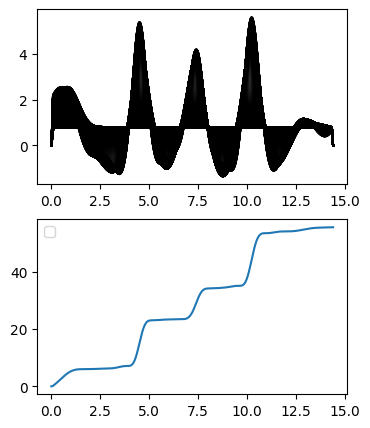

In [531]:
##### NBVAL_IGNORE_OUTPUT
# the DensityMatrixODEPropagator is not sufficiently exact to guarantee that
# you won't get slightly different results in the optimization when
# running this on different systems
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    iter_stop=20000,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-10
    ),
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_qubit_error
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('5e-6', name='J_T'),
        krotov.convergence.check_monotonic_error,
     ),
      store_all_pulses=True,
)

plot_iterations(opt_result)


In [532]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pulse Amplitude')
    plt.show(fig)

In [533]:
def non_optimized(F,omega,tlist):
    non_opt=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        non_opt[i]=F*2*np.cos(omega*tlist[i])
    return non_opt

In [534]:
def purity_charger(state,tlist):
    purity=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        purity[i]=np.real(((state[i].ptrace(0))*(state[i].ptrace(0))).tr())
    return purity

In [535]:
def purity_battery(state,tlist):
    purity=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        purity[i]=np.real(((state[i].ptrace([1,2,3,4]))*(state[i].ptrace([1,2,3,4])))).tr()
    return purity

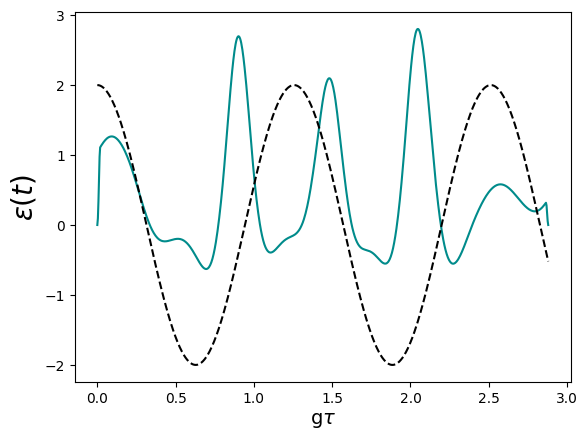

In [536]:
plt.plot(g*tlist,opt_result.optimized_controls[0]/2,color='darkcyan')
plt.plot(g*tlist,non_optimized(2,1,tlist)/2,color='black', linestyle='dashed')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\epsilon(t)$',fontsize=20)
plt.savefig("4_qubit_field.png")

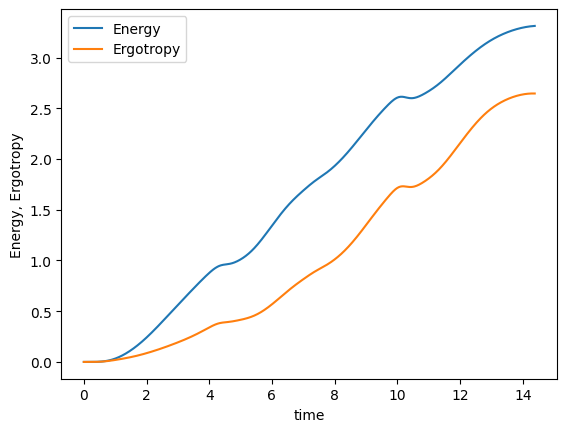

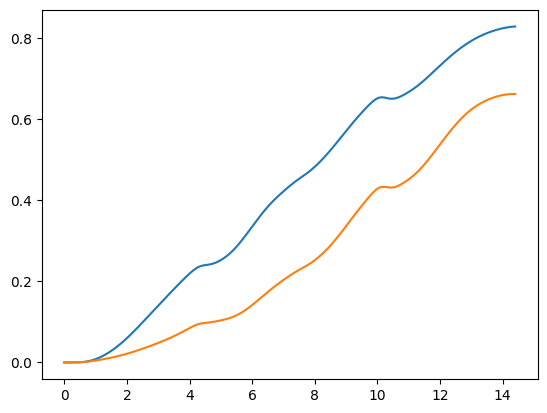

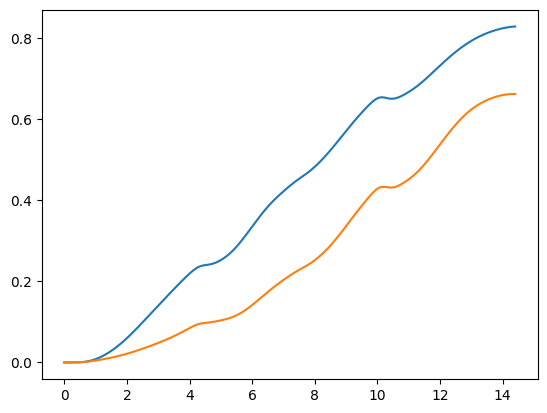

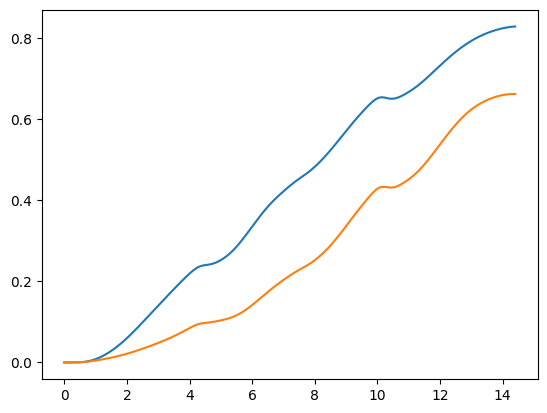

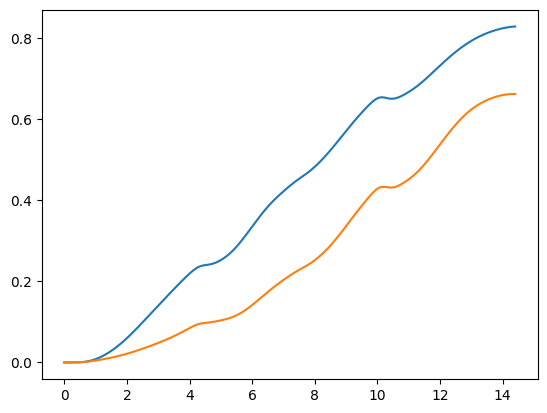

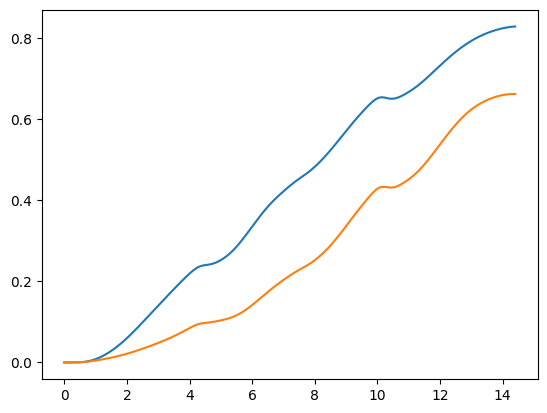

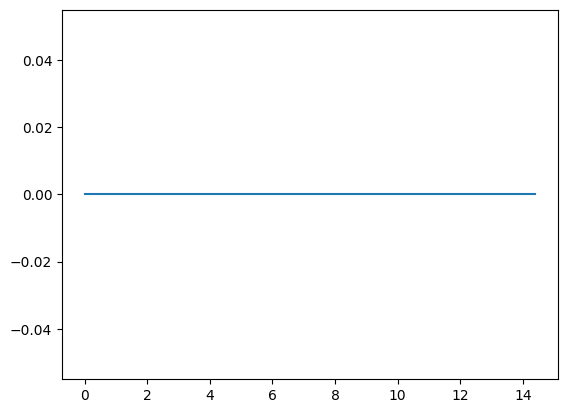

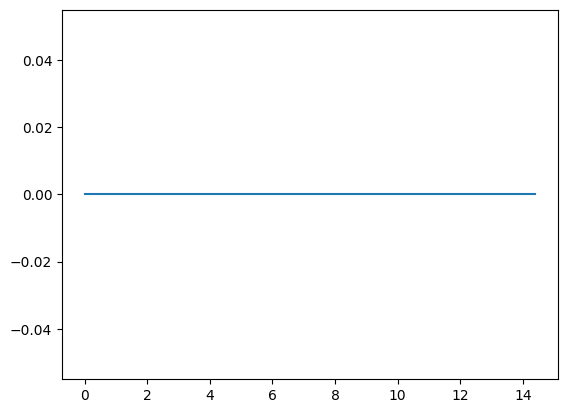

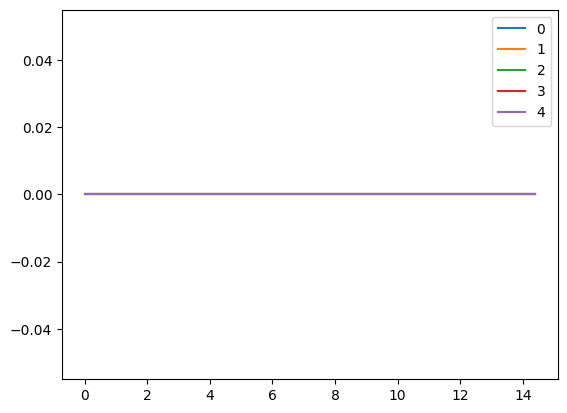

In [552]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
Ergotropy1=np.zeros(nt)
Energy1=np.zeros(nt)
Ergotropy2=np.zeros(nt)
Energy2=np.zeros(nt)
Ergotropy3=np.zeros(nt)
Energy3=np.zeros(nt)
Ergotropy4=np.zeros(nt)
Energy4=np.zeros(nt)
time=np.zeros(nt)
puritycharger=np.zeros(nt)
puritybattery=np.zeros(nt)
population0=np.zeros(nt)
population1=np.zeros(nt)
population2=np.zeros(nt)
population3=np.zeros(nt)
population4=np.zeros(nt)

for i in range(0,nt):
  FinalStateCharger= np.trace(np.array(optimized_dynamics.states[i]).reshape(2,16,2,16), axis1=1, axis2=3)
  #puritycharger[i]=np.real(np.trace(np.dot(FinalStateCharger,FinalStateCharger)))
  FinalStateB = np.trace(np.array(optimized_dynamics.states[i]).reshape(2,2,2,2,2,2,2,2,2,2), axis1=0, axis2=5)
  #population0[i]=FinalStateB[0,0]
  #population1[i]=FinalStateB[1,1]+FinalStateB[2,2]+FinalStateB[4,4]+FinalStateB[8,8]
  #population2[i]=FinalStateB[3,3]+FinalStateB[5,5]+FinalStateB[6,6]+FinalStateB[9,9]+FinalStateB[10,10]+FinalStateB[12,12]
  #population3[i]=FinalStateB[7,7]+FinalStateB[11,11]+FinalStateB[13,13]+FinalStateB[14,14]
  #population4[i]=FinalStateB[15,15]
  #puritybattery[i]=np.trace(np.dot(FinalStateB,FinalStateB))
  FinalStateCell1=np.trace(np.array(FinalStateB).reshape(2,8,2,8), axis1=1, axis2=3)
  PreFinalStateCell2=np.trace(np.array(FinalStateB).reshape(2,2,4,2,2,4), axis1=2, axis2=5)
  FinalStateCell2=np.trace(np.array(PreFinalStateCell2).reshape(2,2,2,2), axis1=0, axis2=2)
  PreFinalStateCell3=np.trace(np.array(FinalStateB).reshape(4,2,2,4,2,2), axis1=0, axis2=3)
  FinalStateCell3=np.trace(np.array(PreFinalStateCell2).reshape(2,2,2,2), axis1=1, axis2=3)
  FinalStateCell4=np.trace(np.array(FinalStateB).reshape(8,2,8,2), axis1=0, axis2=2)    

  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell4=eigenvalues(FinalStateCell4)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell4)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  time[i]=(T/nt)*i
  Energy1[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))
  Ergotropy1[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))
  Energy2[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy2[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  Energy3[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))
  Ergotropy3[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))
  Energy4[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))
  Ergotropy4[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))



plt.plot(time,Energy,label='Energy')
plt.plot(time,Ergotropy,label='Ergotropy')
plt.xlabel("time")
plt.ylabel("Energy, Ergotropy")
plt.legend()  
plt.show()


plt.figure()
plt.plot(tlist,Energy1)
plt.plot(tlist,Ergotropy1)


plt.figure()
plt.plot(tlist,Energy1)
plt.plot(tlist,Ergotropy1)


plt.figure()
plt.plot(tlist,Energy2)
plt.plot(tlist,Ergotropy2)


plt.figure()
plt.plot(tlist,Energy3)
plt.plot(tlist,Ergotropy3)

plt.figure()
plt.plot(tlist,Energy4)
plt.plot(tlist,Ergotropy4)

plt.figure()
plt.plot(tlist,puritycharger)


plt.figure()
plt.plot(tlist,puritybattery)


plt.figure()
plt.plot(tlist,population0,label='0')
plt.plot(tlist,population1,label='1')
plt.plot(tlist,population2,label='2')
plt.plot(tlist,population3,label='3')
plt.plot(tlist,population4,label='4')
plt.legend()

plt.show()

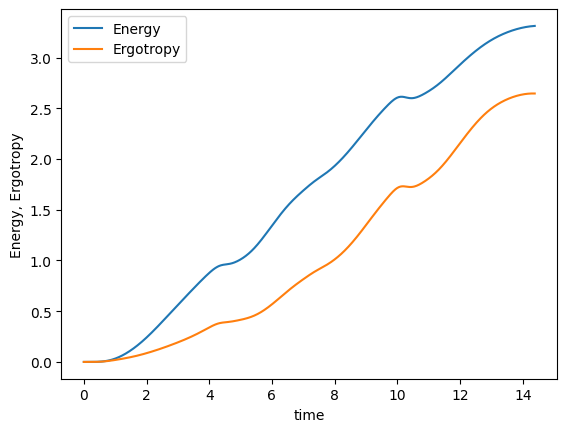

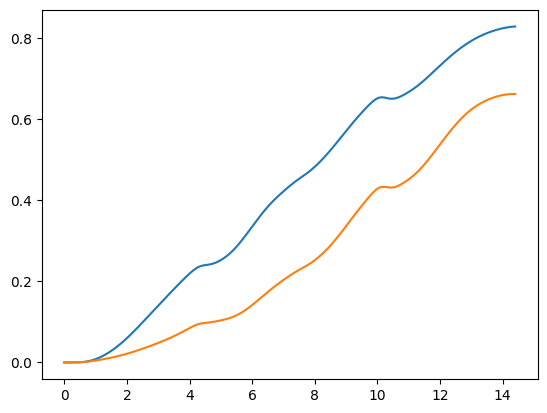

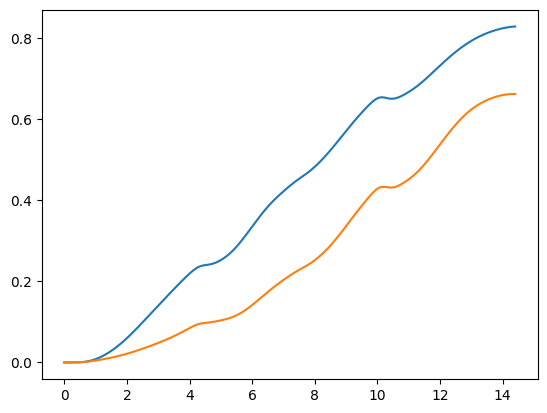

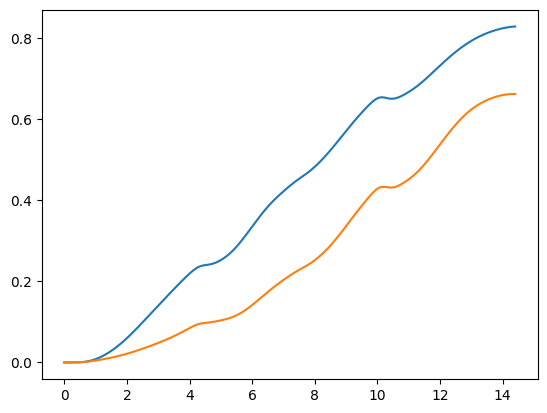

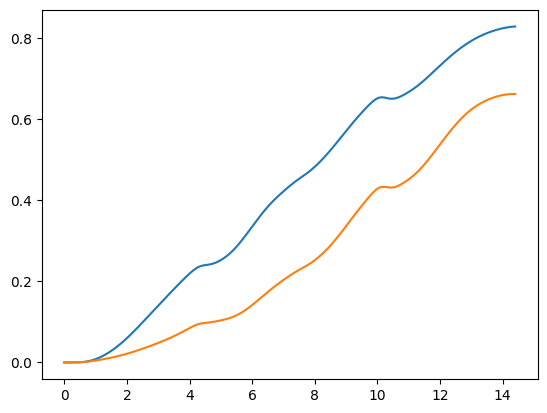

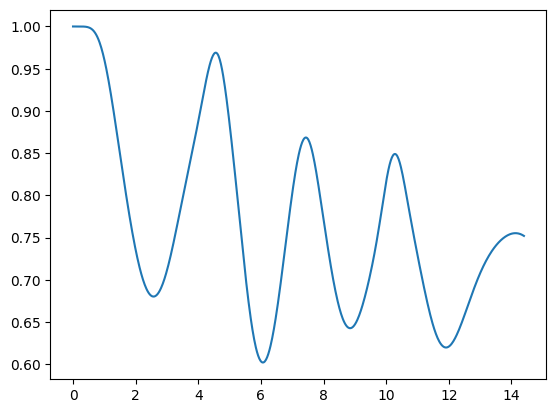

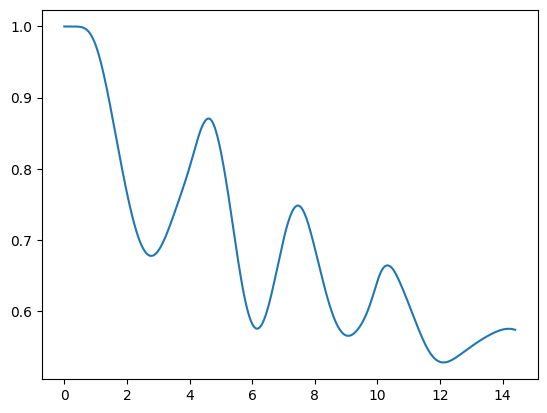

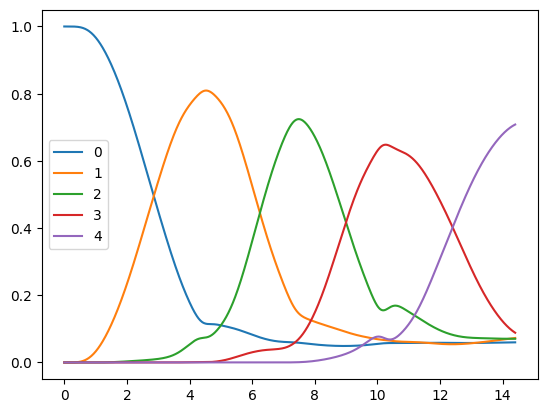

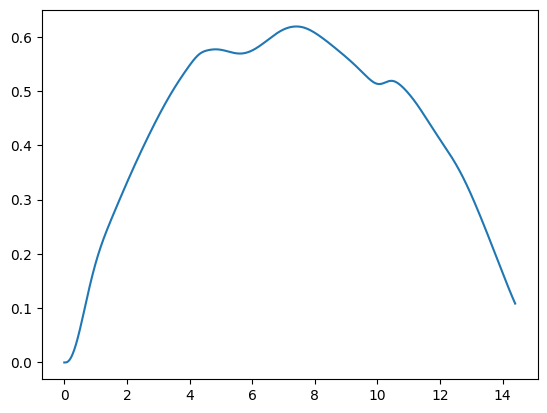

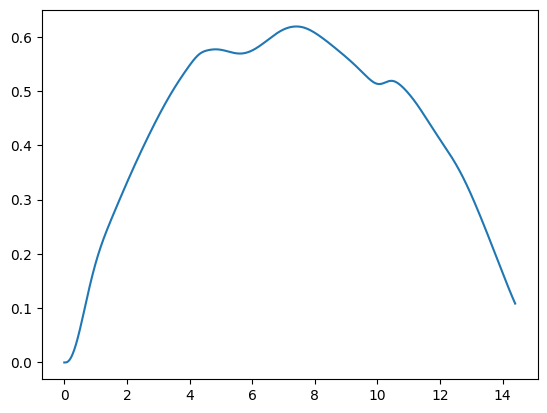

In [553]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
Ergotropy1=np.zeros(nt)
Energy1=np.zeros(nt)
Ergotropy2=np.zeros(nt)
Energy2=np.zeros(nt)
Ergotropy3=np.zeros(nt)
Energy3=np.zeros(nt)
Ergotropy4=np.zeros(nt)
Energy4=np.zeros(nt)
time=np.zeros(nt)
Entanglement=np.zeros(nt)
Entanglement2=np.zeros(nt)
puritycharger=np.zeros(nt)
puritybattery=np.zeros(nt)
population0=np.zeros(nt)
population1=np.zeros(nt)
population2=np.zeros(nt)
population3=np.zeros(nt)
population4=np.zeros(nt)

for i in range(0,nt):
  FinalStateCharger= np.array(optimized_dynamics.states[i].ptrace(0))
  puritycharger[i]=np.real(np.trace(np.dot(FinalStateCharger,FinalStateCharger)))
  FinalStateB = np.array(optimized_dynamics.states[i].ptrace([1,2,3,4]))
  puritybattery[i]=np.real(np.trace(np.dot(FinalStateB,FinalStateB)))
  FinalStateCell1=np.array(optimized_dynamics.states[i].ptrace(1))
  FinalStateCell2=np.array(optimized_dynamics.states[i].ptrace(2))
  FinalStateCell3=np.array(optimized_dynamics.states[i].ptrace(3))
  FinalStateCell4=np.array(optimized_dynamics.states[i].ptrace(4))
  population0[i]=np.real(FinalStateB[0,0])
  population1[i]=np.real(FinalStateB[1,1]+FinalStateB[2,2]+FinalStateB[4,4]+FinalStateB[8,8])
  population2[i]=np.real(FinalStateB[3,3]+FinalStateB[5,5]+FinalStateB[6,6]+FinalStateB[9,9]+FinalStateB[10,10]+FinalStateB[12,12])
  population3[i]=np.real(FinalStateB[7,7]+FinalStateB[11,11]+FinalStateB[13,13]+FinalStateB[14,14])
  population4[i]=np.real(FinalStateB[15,15])
  StateBetweenBatteries=optimized_dynamics.states[i].ptrace([1,2])
  PartialTranspose=qt.partial_transpose(StateBetweenBatteries,[1,0])
  P=np.real(np.trace(np.sqrt(np.array(PartialTranspose.dag()*PartialTranspose))))
  Entanglement[i]=math.log2(P)
  StateBetweenBatteries=optimized_dynamics.states[i].ptrace([1,3])
  PartialTranspose=qt.partial_transpose(StateBetweenBatteries,[1,0])
  P=np.real(np.trace(np.sqrt(np.array(PartialTranspose.dag()*PartialTranspose))))
    
  Entanglement2[i]=math.log2(P)
  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell4=eigenvalues(FinalStateCell4)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell4)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  time[i]=(T/nt)*i
  Energy1[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))
  Ergotropy1[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))
  Energy2[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy2[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  Energy3[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))
  Ergotropy3[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))
  Energy4[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))
  Ergotropy4[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))



plt.plot(time,Energy,label='Energy')
plt.plot(time,Ergotropy,label='Ergotropy')
plt.xlabel("time")
plt.ylabel("Energy, Ergotropy")
plt.legend()  
plt.show()


plt.figure()
plt.plot(tlist,Energy1)
plt.plot(tlist,Ergotropy1)



plt.figure()
plt.plot(tlist,Energy2)
plt.plot(tlist,Ergotropy2)


plt.figure()
plt.plot(tlist,Energy3)
plt.plot(tlist,Ergotropy3)

plt.figure()
plt.plot(tlist,Energy4)
plt.plot(tlist,Ergotropy4)

plt.figure()
plt.plot(tlist,puritycharger)


plt.figure()
plt.plot(tlist,puritybattery)

plt.figure()
plt.plot(tlist,population0,label='0')
plt.plot(tlist,population1,label='1')
plt.plot(tlist,population2,label='2')
plt.plot(tlist,population3,label='3')
plt.plot(tlist,population4,label='4')
plt.legend()

plt.figure()
plt.plot(tlist,Entanglement)

plt.figure()
plt.plot(tlist,Entanglement2)
plt.show()

In [555]:
T=14.4#np.pi/g
EField=np.transpose(np.array(opt_result.optimized_controls))
EEnergy=np.zeros(len(tlist))
EEnergy[0]=(np.square(EField[0]))*(T/nt)
a=0
for i in range (1,nt):
    a+=np.square(EField[i-1])
    EEnergy[i]=(np.square(EField[i])+a)*(T/nt)

print(EEnergy[nt-1]*(0.75)**2)
a=opt_result.states[0].ptrace([1,2,3,4])
print(a[15,15])
a

31.196721269880193
(0.707555335620133-1.8364034127890405e-17j)


Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.05965067+6.48990843e-18j  0.00508144+1.79522690e-03j
   0.00508144+1.79522690e-03j -0.00588333+4.05535254e-03j
   0.00508144+1.79522690e-03j -0.00588333+4.05535254e-03j
  -0.00588333+4.05535254e-03j  0.00178413+1.45813218e-03j
   0.00508144+1.79522690e-03j -0.00588333+4.05535254e-03j
  -0.00588333+4.05535254e-03j  0.00178413+1.45813218e-03j
  -0.00588333+4.05535254e-03j  0.00178413+1.45813218e-03j
   0.00178413+1.45813218e-03j  0.06004605+2.84336675e-02j]
 [ 0.00508144-1.79522690e-03j  0.01805049+1.11836701e-17j
   0.01805049+1.11836701e-17j  0.00115312+3.43232126e-03j
   0.01805049+1.11836701e-17j  0.00115312+3.43232126e-03j
   0.00115312+3.43232126e-03j -0.00249605+5.22569555e-04j
   0.01805049+1.11836701e-17j  0.00115312+3.43232126e-03j
   0.00115312+3.43232126e-03j -0.00249605+5.22569555e-04j
   0.00115312+3.43232126e-03j -0.00249605+5.22569555e-04j
  -0.00249605+5.225

1.687462909268768


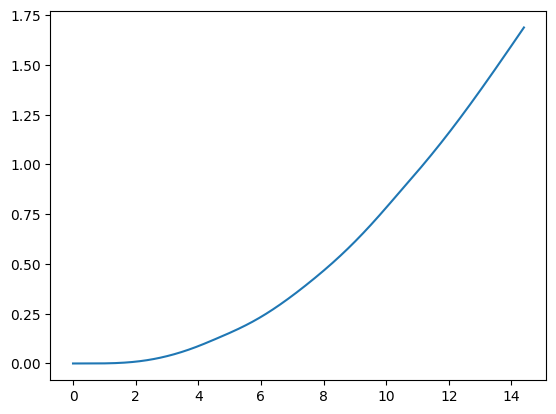

In [556]:
Power=np.zeros(nt)
dt=tlist[1]-tlist[0]
for j in range(0,nt):
  for i in range(0,j+1):
    Power[j]+=1/T*dt*Energy[i]

plt.plot(tlist,Power)
print(Power[nt-1])

In [557]:
def HA_coeff(t, args):
      return  np.exp(-(t*1j*omega))

def HB_coeff(t, args):
      return  np.exp((t*1j*omega))


def hamiltonian(omega, g,F):
    """Liouvillian for the coupled system of qubit and TLS"""
    sminus=qt.Qobj(np.array([[0,1],[0,0]]))
    splus=qt.Qobj(np.array([[0,0],[1,0]]))
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_A = F*splus
    H1_B = F*sminus

    # drift TLS Hamiltonian
    H0_T = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1A = qutip.tensor(H1_A, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    H1B = qutip.tensor(H1_B, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(sminus,splus,qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(splus,sminus,qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(sminus,qutip.qeye(2),splus,qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(splus,qutip.qeye(2),sminus,qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(sminus,qutip.qeye(2),qutip.qeye(2),splus,qutip.qeye(2))\
                +qutip.tensor(splus,qutip.qeye(2),qutip.qeye(2),sminus,qutip.qeye(2))\
                +qutip.tensor(sminus,qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),splus)\
                +qutip.tensor(splus,qutip.qeye(2),qutip.qeye(2),qutip.qeye(2),sminus))
    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1A = qutip.Qobj(H1A)
    H1B = qutip.Qobj(H1B)
    return [H0,[H1A,HA_coeff],[H1B,HB_coeff]]

/tmp/ipykernel_582/3688101962.py:49: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=ergotropy[i]/energy[i]
/tmp/ipykernel_582/3688101962.py:59: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(g*t,Ergotropy/Energy,color='darkcyan')


Text(0, 0.5, '$\\frac{\\mathcal{E}_{B}}{E_B}$')

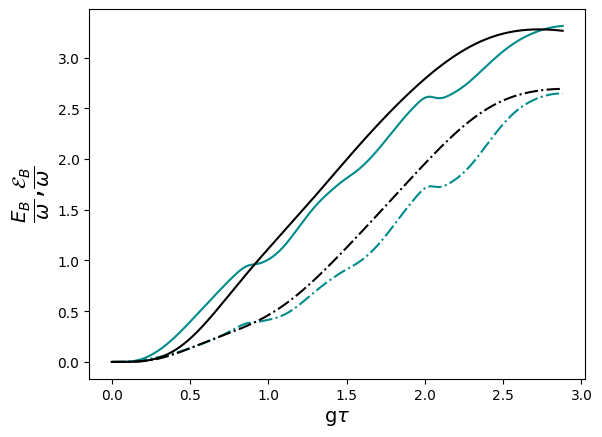

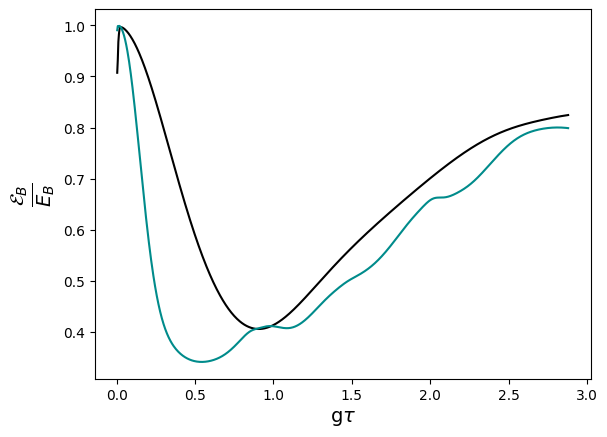

In [558]:
import qutip as qt
import numpy as np
from numpy import linalg as npla
sminus=qt.Qobj(np.array([[0,1],[0,0]]))
splus=qt.Qobj(np.array([[0,0],[1,0]]))
F=0.5
g=0.2
gamma=0.05
omega=1

H=hamiltonian(omega,g,F)
psi0=qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0),qt.basis(2,0),qt.basis(2,0))
T = 14.4#np.pi/g # final time
nt = 800
t=np.linspace(0,T,nt)
N=0
H0 = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

output = qt.mesolve(H, psi0, t, [qt.tensor(np.sqrt(gamma*(N+1))*sminus,qt.qeye(2),qt.qeye(2),qt.qeye(2),qt.qeye(2)),qt.tensor(np.sqrt(gamma*N)*splus,qt.qeye(2),qt.qeye(2),qt.qeye(2),qt.qeye(2))], [])
energy=np.zeros(len(t))
ergotropy=np.zeros(len(t))
ratio=np.zeros(len(t))
for i in range (0,len(t)):
  rho_A=output.states[i].ptrace([1,2,3,4])
  FinalStateCell1=np.array(rho_A.ptrace(0))
  FinalStateCell2=np.array(rho_A.ptrace(1))
  

  FinalStateCell3=np.array(rho_A.ptrace(2))
  FinalStateCell4=np.array(rho_A.ptrace(3))
  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell4=eigenvalues(FinalStateCell4)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell4)[0]*np.array([[0, 0], [0, 1]])
  #energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell4-FinalStateCell4))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  energy[i]=np.real((rho_A*H0).tr())

  #rho_f=qt.Qobj(eigenvalues(rho_A)[1]*qt.basis(2,0)*qt.basis(2,0).dag()+eigenvalues(rho_A)[0]*qt.basis(2,1)*qt.basis(2,1).dag())
  #r=np.sqrt(((rho_A*qt.sigmax()).tr())**2+((rho_A*qt.sigmay()).tr())**2+((rho_A*qt.sigmaz()).tr())**2)
  #sminusexp=(rho_A*sminus).tr()
  #splusexp=(rho_A*splus).tr()
  #zexp=(rho_A*qt.sigmaz()).tr()
  #energy[i]=np.real((rho_A*H0).tr())
  #ergotropy[i]=np.real(((rho_A-rho_f)*H0).tr())
  ratio[i]=ergotropy[i]/energy[i]
plt.plot(g*tlist,np.real(Energy),color='darkcyan')
plt.plot(g*tlist,np.real(Ergotropy),ls='dashdot',color='darkcyan')
plt.plot(g*t,np.real(energy),color='black')
plt.plot(g*t,np.real(ergotropy),ls='dashdot',color='black')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{E_{B}}{\omega}$,$\frac{\mathcal{E}_{B}}{\omega}$',fontsize=20)
plt.savefig("4_qubit_cell.png")
plt.figure()
plt.plot(g*t,ratio,color='black')
plt.plot(g*t,Ergotropy/Energy,color='darkcyan')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{\mathcal{E}_{B}}{E_B}$',fontsize=20)


In [559]:
np.real(Ergotropy)[-1]/ergotropy[-1]

0.9832245221897882

In [560]:
import pruebas

In [561]:
ergotropy[-1]

2.6911811855036736

In [562]:
Ergotropy[-1]

2.6460353352429973

In [563]:
pruebas.field_energy(opt_result,tlist,T,nt)/2

27.73041890656017

In [564]:
(2.879031977469992/2.691181202254379-1)*100

6.980235112308764

In [565]:
(((2*np.pi/g )/(pruebas.field_energy(opt_result,tlist,T,nt) /2))-1)*100

13.290486673700697

In [566]:
(29/ (55.70687166983035/2) -1 )*100

4.116419144411521

In [567]:
55.70687166983035/2

27.853435834915174

## Simulate the dynamics of the optimized field

The plot of the optimized field shows that the optimization slightly shifts
the field such that qubit and TLS are no longer perfectly in resonance.

This slight shift of qubit and TLS out of resonance delays the population
oscillations between qubit and TLS ground state such that the qubit ground
state is maximally populated at final time $T$.

In [ ]:
print(Ergotropy[nt-1]/Energy[nt-1])
print(Ergotropy[nt-1])

In [ ]:
np.argmax(ergotropy)

In [ ]:
t[1999]

In [ ]:
Ergotropy[1999]

In [ ]:
ergotropy[1999]